In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy')
Q_real = np.load('./Q_15minutes.npy')
f_real = Q_real[:,1]
v_real = Q_real[:,3]
pi_real = np.load('./pitilde_15minutes.npy')

Text(0, 0.5, 'Remaining Trip Distance (miles)')

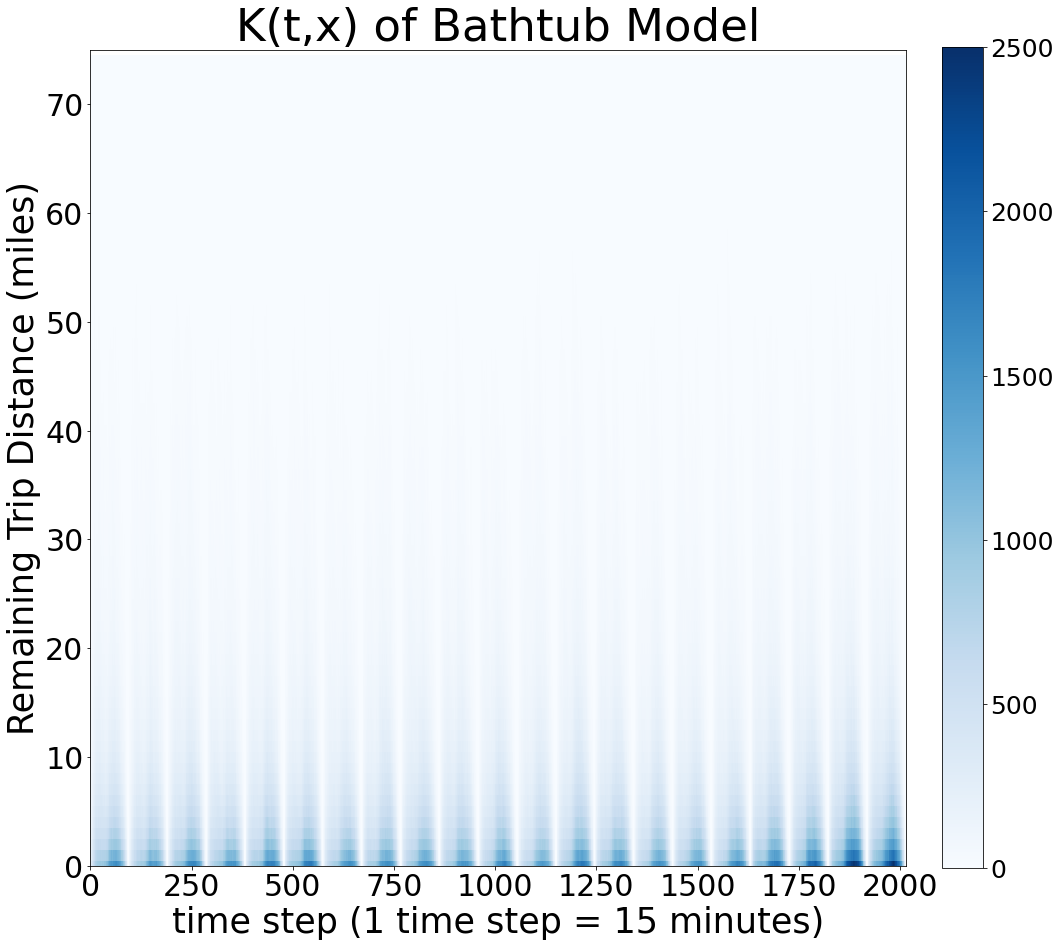

In [3]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [4]:
## Scale
N_timestep = 24*21*4
N_diststep = 75
Size_diststep = 1 # unit: miles
N_trainingdays = 0
N_training = 24*4*N_trainingdays


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]                   # 150 points with 15 mile (distance step)
t = np.arange(0,N_timestep)[:,None]              # 2016 points with 15 minutes (time step) 
usol = K_real.transpose() [:,N_training:]                  # solution of 10 * 2016 grid points 15 miles (distance step)
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [5]:
size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) #Total number of data points for 'u'
N_f = N_u*2 #Total number of collocation points 
alpha = 0.5

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  151200
N_u =  30240
N_f =  60480


In [6]:
# Previous version (before Aug 30)
size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.5) #Total number of data points for 'u'
N_f = N_u*2 #Total number of collocation points 
alpha = 0.5

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  151200
N_u =  75600
N_f =  151200


# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [7]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [8]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T.flatten()[:,None],T.T.flatten()[:,None]))
    all_u_train = usol.flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    test_idx = np.delete(np.arange(size_input), train_idx)

    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [9]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [10]:
X_u_train.shape

(75600, 2)

In [11]:
X_u_test.shape

(75600, 2)

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [12]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [13]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0060497117872482182 0.0060497117872482182 0.8337323406071038
0.0057615250540495981 0.0057615250540495981 0.8134856207481316
0.0050651026085588831 0.0050651026085588831 0.7618259535984124
0.0047883833297093538 0.0047883833297093538 0.7400040984442936
0.0047680837440323585 0.0047680837440323585 0.7383435070272202
0.0047669158158434467 0.0047669158158434467 0.7382571693941591
0.0047656067459903384 0.0047656067459903384 0.7381650254262971
0.0047627471965161492 0.0047627471965161492 0.7379617356295646
0.0047583864905544485 0.0047583864905544485 0.7376456147273315
0.0047504573553957255 0.0047504573553957255 0.7370347504256728
0.0047342442363011708 0.0047342442363011708 0.7357581930211868
0.0047186828878156744 0.0047186828878156744 0.7345083230754982
0.0046733735329195494 0.0046733735329195494 0.7308556036546151
0.004518251899341897 0.004518251899341897 0.7183430513312992
0.0043866680451732859 0.0043866680451732859 0.7076658977499707
0.004171375999924138 0.004171375999924138 0.6900187874424

0.0016469008577398362 0.0016469008577398362 0.43524771650744826
0.001646241139639328 0.001646241139639328 0.43493167609454164
0.001645700661741391 0.001645700661741391 0.4349743124021709
0.0016454555900045134 0.0016454555900045134 0.43504056573915395
0.0016451714642723573 0.0016451714642723573 0.4351845924076132
0.0016448707275948222 0.0016448707275948222 0.4351525259346152
0.0016447493688757657 0.0016447493688757657 0.43513815902521
0.001644687656370956 0.001644687656370956 0.4351819742623802
0.0016446085108925263 0.0016446085108925263 0.43521662973509717
0.0016444386362601216 0.0016444386362601216 0.435247943274574
0.0016441326943281913 0.0016441326943281913 0.4352605442371823
0.0016434249509885289 0.0016434249509885289 0.43527719956390054
0.0016425068652749586 0.0016425068652749586 0.4352154672767926
0.0016416887709500511 0.0016416887709500511 0.4351292398187338
0.001641509274361257 0.001641509274361257 0.4350351175579161
0.0016414630909424631 0.0016414630909424631 0.434926251532688

0.0016245496986797428 0.0016245496986797428 0.434002445774366
0.0016245361305674804 0.0016245361305674804 0.4340125338322761
0.0016245224360736405 0.0016245224360736405 0.4339990377625694
0.0016245079846371423 0.0016245079846371423 0.43401070089958765
0.0016244966117438542 0.0016244966117438542 0.43403108594261613
0.0016244794010771915 0.0016244794010771915 0.43405306026106966
0.0016244673814977254 0.0016244673814977254 0.43406299663568193
0.0016244609464396932 0.0016244609464396932 0.4340347252606006
0.0016244529087010005 0.0016244529087010005 0.4340299922152189
0.0016244463418688705 0.0016244463418688705 0.43403328186293344
0.0016244409523929117 0.0016244409523929117 0.4340343648805364
0.0016244323587918973 0.0016244323587918973 0.43402764354317264
0.0016244285436957813 0.0016244285436957813 0.43402139571605314
0.0016244159649332756 0.0016244159649332756 0.4340117245216288
0.0016243887822480604 0.0016243887822480604 0.4339643983189644
0.0016243500212155726 0.0016243500212155726 0.433

0.0016198780241108242 0.0016198780241108242 0.4335171822474811
0.001619871861586794 0.001619871861586794 0.4335093486986871
0.0016198679431396628 0.0016198679431396628 0.43349898792883873
0.0016198670870319247 0.0016198670870319247 0.4334924956840097
0.001619863304309212 0.001619863304309212 0.4334812637944512
0.001619858950814012 0.001619858950814012 0.43348899072388036
0.0016198566824047601 0.0016198566824047601 0.4334901044710797
0.0016198503273866316 0.0016198503273866316 0.4334915620735138
0.0016198465659340796 0.0016198465659340796 0.43348665144284126
0.001619844675158782 0.001619844675158782 0.43348445913781336
0.0016198431430072451 0.0016198431430072451 0.4334824562844228
0.0016198395101495527 0.0016198395101495527 0.43347884603298265
0.0016198323917436593 0.0016198323917436593 0.43348002319422996
0.0016198175991178746 0.0016198175991178746 0.4334891529091245
0.0016197993416968135 0.0016197993416968135 0.4335031016637896
0.0016197808170696573 0.0016197808170696573 0.43351184265

0.001614759920473806 0.001614759920473806 0.4330671297211568
0.0016147375201089843 0.0016147375201089843 0.43306970622623825
0.0016147251208966829 0.0016147251208966829 0.433069613673119
0.0016147172449543056 0.0016147172449543056 0.43307816115156694
0.0016147134597980272 0.0016147134597980272 0.4330703134592515
0.001614712004312254 0.001614712004312254 0.43307733826197436
0.0016147114105959342 0.0016147114105959342 0.4330772069178931
0.0016147102569574806 0.0016147102569574806 0.43307467181397075
0.0016147090457911204 0.0016147090457911204 0.43306999867228047
0.0016147079673970233 0.0016147079673970233 0.43306469817704474
0.0016147071096580153 0.0016147071096580153 0.43306228632306537
0.0016147045852938657 0.0016147045852938657 0.43305574534876506
0.001614701304974681 0.001614701304974681 0.4330531627389183
0.0016146937599549316 0.0016146937599549316 0.4330499562407824
0.0016146810367087571 0.0016146810367087571 0.4330592151773447
0.0016146757064478628 0.0016146757064478628 0.43305714

0.0016121302934308229 0.0016121302934308229 0.4325273590639131
0.0016121202526536954 0.0016121202526536954 0.4325165243185029
0.0016121102709767202 0.0016121102709767202 0.4325145898976937
0.0016120927129232596 0.0016120927129232596 0.43252422406310115
0.0016120774135185655 0.0016120774135185655 0.43254245239862754
0.0016120692853213009 0.0016120692853213009 0.4325644336055906
0.0016120669723888967 0.0016120669723888967 0.4325816541771524
0.0016120598206643866 0.0016120598206643866 0.4325706473542516
0.0016120535442417803 0.0016120535442417803 0.4325666859013842
0.00161204463160052 0.00161204463160052 0.4325593556297228
0.0016120302959969036 0.0016120302959969036 0.4325670444738547
0.0016120059014222334 0.0016120059014222334 0.43256334269361824
0.0016119717412622176 0.0016119717412622176 0.43253862135308907
0.0016119484304197959 0.0016119484304197959 0.4325420653539621
0.0016118774249362677 0.0016118774249362677 0.4325183259345647
0.0016118609334846415 0.0016118609334846415 0.432529826

0.0016049626827704048 0.0016049626827704048 0.4319061049667365
0.001604933188682748 0.001604933188682748 0.4317926566936019
0.001604855911713323 0.001604855911713323 0.43183519430005374
0.0016047348701399278 0.0016047348701399278 0.43186809470442306
0.0016046122932154917 0.0016046122932154917 0.4318489420337682
0.0016044708567949542 0.0016044708567949542 0.4317848039499713
0.0016043663665305705 0.0016043663665305705 0.43175213359122006
0.0016042844926117241 0.0016042844926117241 0.4316701906161699
0.0016042214246228786 0.0016042214246228786 0.43164811786188156
0.0016041927859749999 0.0016041927859749999 0.43166207854702304
0.0016041124705010765 0.0016041124705010765 0.431683122157162
0.0016040307879851695 0.0016040307879851695 0.43167933788302826
0.0016039550418539606 0.0016039550418539606 0.43167252962936525
0.0016038838511992707 0.0016038838511992707 0.43167145283517117
0.001603803588980142 0.001603803588980142 0.4316850350364352
0.0016037856833256896 0.0016037856833256896 0.43167175

0.0015996630117114696 0.0015996630117114696 0.4309554466712401
0.0015996527450291721 0.0015996527450291721 0.43097523705710855
0.0015996403066872989 0.0015996403066872989 0.43095249273220665
0.0015996305910619627 0.0015996305910619627 0.4309749514936796
0.0015996196299720789 0.0015996196299720789 0.43096206951085936
0.0015996110039261878 0.0015996110039261878 0.430959442523123
0.0015996047827633055 0.0015996047827633055 0.4309624179464854
0.001599602177908823 0.001599602177908823 0.4309569913245914
0.001599597913784085 0.001599597913784085 0.4309491588259228
0.0015995959841969166 0.0015995959841969166 0.43096701950612676
0.0015995903501968606 0.0015995903501968606 0.43095287908772817
0.0015995851838844217 0.0015995851838844217 0.4309394512998787
0.0015995767501464223 0.0015995767501464223 0.4309297135775216
0.0015995635465963498 0.0015995635465963498 0.430918395457009
0.0015995370518311885 0.0015995370518311885 0.4309071202433415
0.0015995293504676856 0.0015995293504676856 0.4309078333

0.0015981437157648996 0.0015981437157648996 0.4307597392967778
0.0015981032075302953 0.0015981032075302953 0.43073526630590064
0.0015980794973472787 0.0015980794973472787 0.4307431625062553
0.0015980666693921751 0.0015980666693921751 0.4307198577100422
0.0015980548155312545 0.0015980548155312545 0.4307322878452713
0.0015980233909387456 0.0015980233909387456 0.4307495529211591
0.0015980047648827859 0.0015980047648827859 0.43077659549152436
0.0015979873180792198 0.0015979873180792198 0.43076150601641033
0.0015979754607515278 0.0015979754607515278 0.43078843262910593
0.0015979648190748846 0.0015979648190748846 0.4308043967882783
0.0015979510786049587 0.0015979510786049587 0.4307345227959415
0.00159793518325489 0.00159793518325489 0.4307117063134831
0.0015979175545200583 0.0015979175545200583 0.43076186993395654
0.0015978944477891585 0.0015978944477891585 0.4307754472226341
0.0015978564952006131 0.0015978564952006131 0.4307517147193815
0.0015978134815486282 0.0015978134815486282 0.43074790

0.0015963053281602536 0.0015963053281602536 0.4304954613564895
0.0015963049302569875 0.0015963049302569875 0.4304921325997087
0.0015963045710851737 0.0015963045710851737 0.430489215480326
0.0015963042087029963 0.0015963042087029963 0.43048668852520794
0.0015963036631484783 0.0015963036631484783 0.4304829256001897
0.0015963030022094495 0.0015963030022094495 0.43048146347710603
0.0015963025618118065 0.0015963025618118065 0.4304786499932871
0.0015963022546099416 0.0015963022546099416 0.4304829484957769
0.0015963019229200436 0.0015963019229200436 0.4304836007069411
0.0015963015555429917 0.0015963015555429917 0.4304845719080855
0.0015963010725195564 0.0015963010725195564 0.43048373554519087
0.0015962996011840793 0.0015962996011840793 0.4304780459679498
0.0015962983438179976 0.0015962983438179976 0.4304777123613623
0.0015962964596170938 0.0015962964596170938 0.43047476291850384
0.0015962949482866027 0.0015962949482866027 0.4304735694367926
0.00159629447433058 0.00159629447433058 0.4304743202

0.0015961582633922289 0.0015961582633922289 0.4305018397060928
0.0015961574779338556 0.0015961574779338556 0.4305013613521155
0.0015961567494670161 0.0015961567494670161 0.4305014667358777
0.0015961554524980966 0.0015961554524980966 0.43049924564134207
0.0015961551818542616 0.0015961551818542616 0.4304974570696168
0.0015961540097857063 0.0015961540097857063 0.4304976113049326
0.0015961539712098442 0.0015961539712098442 0.43049579890131895
0.0015961531008868749 0.0015961531008868749 0.43049785696105247
0.00159615258539058 0.00159615258539058 0.43049958024439267
0.0015961519022465313 0.0015961519022465313 0.4305006558305152
0.0015961511362527982 0.0015961511362527982 0.430500858672135
0.0015961508369819796 0.0015961508369819796 0.4304978868763376
0.0015961503902901571 0.0015961503902901571 0.4304965436501782
0.0015961501593866939 0.0015961501593866939 0.43049703550525686
0.0015961497144611964 0.0015961497144611964 0.4304994052993117
0.0015961488177398504 0.0015961488177398504 0.430497408

0.0015959210775709917 0.0015959210775709917 0.43047654256985746
0.0015959189220286726 0.0015959189220286726 0.43047653076556325
0.0015959158994759029 0.0015959158994759029 0.4304824158292218
0.0015959138943893369 0.0015959138943893369 0.4304782127864247
0.00159591184914548 0.00159591184914548 0.4304681411660868
0.0015959085376751024 0.0015959085376751024 0.43047338642456234
0.001595902850696928 0.001595902850696928 0.4304764658134724
0.0015958985446665195 0.0015958985446665195 0.43048734721630116
0.001595892487309556 0.001595892487309556 0.4304645869186226
0.0015958848223160144 0.0015958848223160144 0.4304484301469523
0.0015958823662147903 0.0015958823662147903 0.43046885838554727
0.0015958803118714027 0.0015958803118714027 0.43047070885853705
0.0015958791634763532 0.0015958791634763532 0.4304528374647289
0.0015958772238447963 0.0015958772238447963 0.4304584440566249
0.0015958730897819224 0.0015958730897819224 0.43046771025788677
0.0015958680882071172 0.0015958680882071172 0.4304722056

0.0015952004934329449 0.0015952004934329449 0.43055530678919435
0.0015951972997238629 0.0015951972997238629 0.4305569800060439
0.0015951964554213451 0.0015951964554213451 0.43055151161245786
0.0015951950465647898 0.0015951950465647898 0.4305487036987667
0.0015951944628198474 0.0015951944628198474 0.43054892351707635
0.0015951934045846726 0.0015951934045846726 0.43054865139863824
0.0015951920198289578 0.0015951920198289578 0.43053888410648267
0.0015951913386735004 0.0015951913386735004 0.43053456857733935
0.0015951903832812115 0.0015951903832812115 0.4305308356642953
0.0015951897316431314 0.0015951897316431314 0.4305314672928326
0.0015951889433941295 0.0015951889433941295 0.43053514060182346
0.0015951884988931696 0.0015951884988931696 0.43053250005425503
0.0015951881261889182 0.0015951881261889182 0.430532443979728
0.0015951876409080719 0.0015951876409080719 0.43053360190897194
0.0015951870335317616 0.0015951870335317616 0.4305342624963261
0.001595185998463824 0.001595185998463824 0.430

0.0015947490038103085 0.0015947490038103085 0.43060394856802264
0.0015947479311729136 0.0015947479311729136 0.43060559007258536
0.0015947462814610645 0.0015947462814610645 0.43060662809113087
0.0015947450145994088 0.0015947450145994088 0.43061680957056603
0.0015947409484816937 0.0015947409484816937 0.43060741213581755
0.0015947389640488692 0.0015947389640488692 0.4306016898576779
0.0015947338535501775 0.0015947338535501775 0.43059572332819207
0.0015947301210900728 0.0015947301210900728 0.43059702792378857
0.0015947255940595758 0.0015947255940595758 0.4305952019766032
0.001594723450622997 0.001594723450622997 0.4305950737736166
0.0015947194399294395 0.0015947194399294395 0.4305995475855538
0.0015947169737732677 0.0015947169737732677 0.4306089959990251
0.0015947147000332108 0.0015947147000332108 0.43062707973089714
0.001594711255327328 0.001594711255327328 0.4306287600058778
0.0015947074434626367 0.0015947074434626367 0.43061978318128213
0.0015947036356828287 0.0015947036356828287 0.4306

0.001593699852240348 0.001593699852240348 0.431144007661218
0.0015936867291316819 0.0015936867291316819 0.4311363437718105
0.0015936798729231376 0.0015936798729231376 0.43113868473884653
0.0015936707403986369 0.0015936707403986369 0.43113305954979725
0.0015936630018073274 0.0015936630018073274 0.4311284902726401
0.0015936449853253811 0.0015936449853253811 0.4311377472202332
0.001593637222173829 0.001593637222173829 0.43112949176935267
0.0015936280553965961 0.0015936280553965961 0.43111165178607913
0.0015936236060452825 0.0015936236060452825 0.43110992055796205
0.0015936208733505668 0.0015936208733505668 0.4311212137880424
0.0015936170567321121 0.0015936170567321121 0.4311101729329117
0.0015936123589466342 0.0015936123589466342 0.4311039914707702
0.0015936110622009048 0.0015936110622009048 0.4310866210986847
0.0015936052214378786 0.0015936052214378786 0.4311028779103562
0.0015936017705137431 0.0015936017705137431 0.4311042084337953
0.001593599205017397 0.001593599205017397 0.43109984981

0.0015929745107873352 0.0015929745107873352 0.4313029645937737
0.0015929682279036284 0.0015929682279036284 0.43131763492063063
0.0015929646653681164 0.0015929646653681164 0.4313171786394366
0.0015929630947698387 0.0015929630947698387 0.4313415010111316
0.0015929573643642747 0.0015929573643642747 0.4313388867873541
0.0015929566723374765 0.0015929566723374765 0.43133724745080454
0.0015929549018768724 0.0015929549018768724 0.4313317904971535
0.0015929528794763257 0.0015929528794763257 0.4313364783924036
0.0015929491008956455 0.0015929491008956455 0.4313298392369454
0.00159294516208763 0.00159294516208763 0.43132715781418884
0.0015929418223168917 0.0015929418223168917 0.4313102481580778
0.001592940237183377 0.001592940237183377 0.43129573292743983
0.0015929381266693685 0.0015929381266693685 0.4313062411899639
0.0015929371664163527 0.0015929371664163527 0.4313140508185911
0.0015929358871540507 0.0015929358871540507 0.43131634059238194
0.0015929339159935997 0.0015929339159935997 0.4313155860

0.0015925721394534572 0.0015925721394534572 0.43134737047608046
0.00159257061551129 0.00159257061551129 0.43134152034932616
0.0015925679323375672 0.0015925679323375672 0.43131820834184853
0.0015925661306321413 0.0015925661306321413 0.4313080426055911
0.0015925639401300586 0.0015925639401300586 0.43130158042283945
0.0015925620627495547 0.0015925620627495547 0.43129929390469635
0.0015925580036361645 0.0015925580036361645 0.4313120501999528
0.0015925551945497997 0.0015925551945497997 0.4313310359399428
0.00159255452564567 0.00159255452564567 0.4313327778633239
0.0015925530508089528 0.0015925530508089528 0.4313272078931718
0.0015925522795177923 0.0015925522795177923 0.4313257393720316
0.001592551289172706 0.001592551289172706 0.43132934449782767
0.0015925485143453853 0.0015925485143453853 0.43133485373745223
0.0015925465500143403 0.0015925465500143403 0.4313373480945961
0.0015925454166395513 0.0015925454166395513 0.4313333014910875
0.0015925442147272614 0.0015925442147272614 0.431326424757

0.0015918591656081415 0.0015918591656081415 0.4313612206284247
0.0015918562252430831 0.0015918562252430831 0.43134658198429704
0.0015918544112423329 0.0015918544112423329 0.43133896029787894
0.0015918518729056753 0.0015918518729056753 0.4313432201059135
0.001591843088901698 0.001591843088901698 0.43137166972167773
0.0015918364684739282 0.0015918364684739282 0.4313695493304464
0.0015918309725370546 0.0015918309725370546 0.43137777146924045
0.0015918265538989525 0.0015918265538989525 0.43137823242890055
0.0015918244458755389 0.0015918244458755389 0.43136169267932273
0.0015918189437532032 0.0015918189437532032 0.4313453753408397
0.001591809102240537 0.001591809102240537 0.43130461383313007
0.0015918073919127715 0.0015918073919127715 0.4312895285667415
0.0015918034170366614 0.0015918034170366614 0.43128140145049515
0.0015917990192375543 0.0015917990192375543 0.4313090773583207
0.0015917950975023083 0.0015917950975023083 0.43131030997456965
0.001591789401736542 0.001591789401736542 0.431337

0.0015912752809486897 0.0015912752809486897 0.4313542549958689
0.0015912698410237053 0.0015912698410237053 0.4313451063618895
0.0015912656590493261 0.0015912656590493261 0.43136508596996054
0.0015912636579716113 0.0015912636579716113 0.43137131317243754
0.0015912622598575898 0.0015912622598575898 0.43138883218068913
0.0015912608452893005 0.0015912608452893005 0.43139199487070623
0.0015912598600835415 0.0015912598600835415 0.43137671296936414
0.0015912592986341216 0.0015912592986341216 0.43137191917742396
0.0015912588398454852 0.0015912588398454852 0.43136764496696905
0.0015912582473919009 0.0015912582473919009 0.43136987134469795
0.0015912575133971102 0.0015912575133971102 0.4313746184998762
0.0015912571936057939 0.0015912571936057939 0.43138007357375546
0.00159125658566416 0.00159125658566416 0.43138076866585584
0.0015912559168426246 0.0015912559168426246 0.43137628741909884
0.0015912551506930678 0.0015912551506930678 0.4313810820636224
0.0015912543733375621 0.0015912543733375621 0.43

0.0015906472743698065 0.0015906472743698065 0.4311573293003593
0.0015906424727205658 0.0015906424727205658 0.43115093277357663
0.0015906369939222766 0.0015906369939222766 0.4311328636896507
0.0015906313503019976 0.0015906313503019976 0.4311356821402485
0.0015906237343801366 0.0015906237343801366 0.43112717620738544
0.0015906172185064179 0.0015906172185064179 0.4311103644635196
0.0015906109907360985 0.0015906109907360985 0.431112765438136
0.0015906059534148826 0.0015906059534148826 0.43112727961390984
0.0015906037347614063 0.0015906037347614063 0.43112584116443653
0.0015905992801158572 0.0015905992801158572 0.4311056151867091
0.0015905940244640676 0.0015905940244640676 0.4310941276003628
0.0015905889065109509 0.0015905889065109509 0.431053539746021
0.0015905850068793186 0.0015905850068793186 0.4310559742103321
0.0015905822645319043 0.0015905822645319043 0.431062006452197
0.0015905794392485552 0.0015905794392485552 0.4310478863419198
0.0015905768247370183 0.0015905768247370183 0.43103231

0.0015897453628279613 0.0015897453628279613 0.4309251429979331
0.0015897296009786612 0.0015897296009786612 0.43097745395100023
0.0015897189750468976 0.0015897189750468976 0.4309535160271635
0.001589699008729905 0.001589699008729905 0.43095944303661593
0.0015896924383101321 0.0015896924383101321 0.4309820821362487
0.0015896853431629672 0.0015896853431629672 0.43097805656271904
0.0015896729929146516 0.0015896729929146516 0.4310001086148729
0.0015896663978073032 0.0015896663978073032 0.4311018576248914
0.0015896467549434612 0.0015896467549434612 0.43106607965364646
0.0015896312276318487 0.0015896312276318487 0.4310529293853443
0.0015896172621579546 0.0015896172621579546 0.4311555269047027
0.0015896078508432108 0.0015896078508432108 0.4312043954013666
0.0015895825798213075 0.0015895825798213075 0.4311107846067691
0.0015895636082712199 0.0015895636082712199 0.4311655495223304
0.0015895430456083581 0.0015895430456083581 0.431162030257672
0.0015895227289893469 0.0015895227289893469 0.43120305

0.0015865267413117357 0.0015865267413117357 0.4307178042206093
0.0015865069752587367 0.0015865069752587367 0.4307166965733305
0.0015864638158066468 0.0015864638158066468 0.43077405263189883
0.0015864423329438482 0.0015864423329438482 0.4307626812804461
0.0015863657697793032 0.0015863657697793032 0.43074524256870667
0.0015863312542559902 0.0015863312542559902 0.430743728981189
0.0015862728567526026 0.0015862728567526026 0.43069361362938224
0.0015861980646836604 0.0015861980646836604 0.4307285591838784
0.0015861764826172078 0.0015861764826172078 0.4307003137875071
0.0015860839771806782 0.0015860839771806782 0.430728652064413
0.0015859783497941802 0.0015859783497941802 0.4308022912675473
0.0015858989761850665 0.0015858989761850665 0.43082726801163135
0.001585831250148513 0.001585831250148513 0.4307847302350651
0.0015856795099081157 0.0015856795099081157 0.43083535590460054
0.0015854933781626129 0.0015854933781626129 0.43080725387299856
0.001585360784839435 0.001585360784839435 0.430743279

0.0015567533970599315 0.0015567533970599315 0.4247505266566466
0.0015558808443563372 0.0015558808443563372 0.424835433226191
0.0015548527075220967 0.0015548527075220967 0.4246485703658182
0.0015541791073866386 0.0015541791073866386 0.4245653088935706
0.0015533286404478073 0.0015533286404478073 0.42428596680673797
0.0015522673323649947 0.0015522673323649947 0.42418132171262296
0.0015516735527324327 0.0015516735527324327 0.42430897814802726
0.0015507345899556748 0.0015507345899556748 0.4243272392827147
0.001549910220793324 0.001549910220793324 0.42413484748052094
0.0015491463986531235 0.0015491463986531235 0.42420426403726286
0.0015479810427422517 0.0015479810427422517 0.42402618663851344
0.0015472043536408661 0.0015472043536408661 0.42377524146644013
0.0015464750764161087 0.0015464750764161087 0.42364708963516146
0.0015454455006995269 0.0015454455006995269 0.4234906218625677
0.0015447659903454055 0.0015447659903454055 0.4235458733755218
0.001544131521695506 0.001544131521695506 0.423473

0.0014986407420766029 0.0014986407420766029 0.41908674886210373
0.0014984933112503075 0.0014984933112503075 0.4189737876324355
0.0014983405971555979 0.0014983405971555979 0.4189729275542835
0.001498066785227558 0.001498066785227558 0.4191169964359468
0.0014979072136756938 0.0014979072136756938 0.41906415790037094
0.0014977095953676066 0.0014977095953676066 0.41906984342169157
0.0014976035220528308 0.0014976035220528308 0.41897592280688845
0.0014974928547857277 0.0014974928547857277 0.41904889285611546
0.0014974092979429137 0.0014974092979429137 0.4191014589938782
0.0014973507504599747 0.0014973507504599747 0.419000929293849
0.0014972873403167762 0.0014972873403167762 0.4189797142943831
0.001497208412062398 0.001497208412062398 0.41894523571703324
0.0014971454980614888 0.0014971454980614888 0.4189208986481409
0.0014970943994060658 0.0014970943994060658 0.4189203601451255
0.0014970485589837694 0.0014970485589837694 0.4189490235221362
0.0014969759837997858 0.0014969759837997858 0.41896993

0.0014853046045479646 0.0014853046045479646 0.4163940538908198
0.0014852551437684416 0.0014852551437684416 0.4163610546216917
0.0014851585591846139 0.0014851585591846139 0.4163481133491207
0.0014850935606503378 0.0014850935606503378 0.4162834556783488
0.0014849712581500372 0.0014849712581500372 0.4164161831960624
0.0014848962903483347 0.0014848962903483347 0.41640015972568784
0.0014848274685673982 0.0014848274685673982 0.41638274129451075
0.0014847523950442263 0.0014847523950442263 0.4164116936049505
0.0014845970587183854 0.0014845970587183854 0.41633616415211233
0.001484445283252587 0.001484445283252587 0.4163757889541344
0.0014842431185897583 0.0014842431185897583 0.41649534127759347
0.0014840294913212578 0.0014840294913212578 0.41646108580287894
0.001483853583585935 0.001483853583585935 0.41641313639946725
0.0014837042137113819 0.0014837042137113819 0.4164178733935911
0.0014835720632369672 0.0014835720632369672 0.41643086737075186
0.0014834735454998514 0.0014834735454998514 0.416474

0.0014746510608867629 0.0014746510608867629 0.4149174198586251
0.0014744906523467725 0.0014744906523467725 0.4148362747656804
0.0014743715097579404 0.0014743715097579404 0.4148241040450395
0.0014743010543326427 0.0014743010543326427 0.41483414627863047
0.0014742098670048037 0.0014742098670048037 0.41480917442702614
0.001474125313262893 0.001474125313262893 0.4148189327093324
0.0014740025380835973 0.0014740025380835973 0.4149041820377935
0.0014738818122072101 0.0014738818122072101 0.4147922313304937
0.0014738409908545934 0.0014738409908545934 0.41485201455595405
0.0014737624973318647 0.0014737624973318647 0.41477511322342203
0.0014737241379810279 0.0014737241379810279 0.41478144380245474
0.0014736723628947031 0.0014736723628947031 0.4147732173552697
0.0014736537225300218 0.0014736537225300218 0.4147609829490996
0.0014735966084065805 0.0014735966084065805 0.4147421513285906
0.0014735484503467695 0.0014735484503467695 0.4147323217016476
0.0014735036212943403 0.0014735036212943403 0.414731

0.0014551462988967594 0.0014551462988967594 0.4124648744125868
0.001454988264081419 0.001454988264081419 0.4125169047322804
0.0014546350536237241 0.0014546350536237241 0.41248432889923636
0.0014543380008240287 0.0014543380008240287 0.41236787387741614
0.0014541348965754913 0.0014541348965754913 0.4122620438245324
0.001453601353525979 0.001453601353525979 0.4121768584049378
0.0014529315982788149 0.0014529315982788149 0.4121332337332973
0.0014523605843261064 0.0014523605843261064 0.41217518865288927
0.001452089373323447 0.001452089373323447 0.4120910664567292
0.0014517405493276808 0.0014517405493276808 0.4119359418401527
0.0014514946069594523 0.0014514946069594523 0.4119504561493364
0.0014508364242172835 0.0014508364242172835 0.4118483109047744
0.0014504019239471456 0.0014504019239471456 0.41171241568683165
0.0014499180178818758 0.0014499180178818758 0.4116564240564465
0.0014497790267580784 0.0014497790267580784 0.4115642091871695
0.00144933836762646 0.00144933836762646 0.411539896433801

0.00138464087190642 0.00138464087190642 0.4005885470006039
0.0013845811002891782 0.0013845811002891782 0.4006078901933147
0.00138448983361176 0.00138448983361176 0.40059596180924084
0.0013843286974345192 0.0013843286974345192 0.4005856170981277
0.0013838526658809828 0.0013838526658809828 0.4005139631696214
0.0013831086074451598 0.0013831086074451598 0.4003314662409122
0.0013825816819684905 0.0013825816819684905 0.40028970436149
0.001381792162221983 0.001381792162221983 0.4001275193143268
0.0013811763712352541 0.0013811763712352541 0.4001723991749212
0.0013809301575303011 0.0013809301575303011 0.40017747421351396
0.0013807156330619705 0.0013807156330619705 0.40029091594202987
0.0013805429925631549 0.0013805429925631549 0.4002799043734564
0.0013802544284372831 0.0013802544284372831 0.40015440208871506
0.0013801648149708125 0.0013801648149708125 0.4001924636777864
0.0013801013128759538 0.0013801013128759538 0.400173992967567
0.0013800402993122028 0.0013800402993122028 0.400176324748233
0.

0.0013628752153322782 0.0013628752153322782 0.39752764590954015
0.001362830802709647 0.001362830802709647 0.39755357714586304
0.0013627386351679354 0.0013627386351679354 0.3975601814084108
0.0013626795071365807 0.0013626795071365807 0.39756316231028316
0.0013626105886032742 0.0013626105886032742 0.3975620646790493
0.001362517817530718 0.001362517817530718 0.39758730656939245
0.0013624553228781177 0.0013624553228781177 0.39761649202306143
0.0013624206634823184 0.0013624206634823184 0.39759180026195357
0.0013623987326215137 0.0013623987326215137 0.3976019844010966
0.0013623805792465549 0.0013623805792465549 0.39760135388530843
0.0013623591570007224 0.0013623591570007224 0.39758871334121604
0.0013623373418736871 0.0013623373418736871 0.3975681479521926
0.0013622945997637116 0.0013622945997637116 0.397531462260676
0.001362237911790926 0.001362237911790926 0.3974989754324896
0.0013621686902285212 0.0013621686902285212 0.3974527509233652
0.0013620976240618576 0.0013620976240618576 0.39744409

0.0013449391781026731 0.0013449391781026731 0.395140050485545
0.0013448532103220313 0.0013448532103220313 0.39511467750694795
0.0013447497607773388 0.0013447497607773388 0.3950399061662611
0.0013447168316524324 0.0013447168316524324 0.3950433993690633
0.0013446862314453159 0.0013446862314453159 0.3950539842073745
0.0013446408680892917 0.0013446408680892917 0.3950324209698101
0.0013446194542990929 0.0013446194542990929 0.39506187191011155
0.001344607579425587 0.001344607579425587 0.3950746388295851
0.0013445899280350203 0.0013445899280350203 0.39509926784009824
0.0013445810431363741 0.0013445810431363741 0.3951141076274861
0.0013445719218793996 0.0013445719218793996 0.3951121340728973
0.0013445645650915117 0.0013445645650915117 0.39511565199952203
0.0013445549678018167 0.0013445549678018167 0.39512369275975834
0.0013445349093770492 0.0013445349093770492 0.39513556367930147
0.00134449086924204 0.00134449086924204 0.3951519427881463
0.0013444293064604608 0.0013444293064604608 0.3951348332

0.0013362378799656456 0.0013362378799656456 0.3940149442228766
0.0013361487144681087 0.0013361487144681087 0.3939761923697303
0.0013361423914498584 0.0013361423914498584 0.3939734454766497
0.0013361249319239186 0.0013361249319239186 0.39398699037546314
0.0013361018355633996 0.0013361018355633996 0.39401370528504437
0.0013360833777804261 0.0013360833777804261 0.39400458902881236
0.0013360778591938486 0.0013360778591938486 0.39400117841471244
0.001336066857720722 0.001336066857720722 0.3939998740325942
0.0013360584600486513 0.0013360584600486513 0.39400539347147334
0.0013360536821474293 0.0013360536821474293 0.39400150808720275
0.0013360438507439714 0.0013360438507439714 0.39400145776124196
0.0013360248636308885 0.0013360248636308885 0.39399903245032414
0.0013360143915733982 0.0013360143915733982 0.39400236303170055
0.001335999159248268 0.001335999159248268 0.3939943622396385
0.0013359849827173267 0.0013359849827173267 0.3939908173998145
0.0013359732348994955 0.0013359732348994955 0.3939

0.0013318642243910488 0.0013318642243910488 0.3933431352255186
0.0013318425168653673 0.0013318425168653673 0.3933595080377506
0.001331795189490259 0.001331795189490259 0.3933711723827981
0.0013317472606953398 0.0013317472606953398 0.39337303170980337
0.0013316720381313905 0.0013316720381313905 0.3933777693979787
0.0013315908930914948 0.0013315908930914948 0.39337966869114444
0.0013315420800372282 0.0013315420800372282 0.39337480332495794
0.0013314924089333695 0.0013314924089333695 0.39336259590197964
0.0013313909048502134 0.0013313909048502134 0.3933623033848449
0.0013312662134102088 0.0013312662134102088 0.39335953790582195
0.0013312154736617749 0.0013312154736617749 0.3934217543556505
0.0013311198420240672 0.0013311198420240672 0.3934288126784769
0.001331061460176164 0.001331061460176164 0.3934227157479272
0.0013309774044292224 0.0013309774044292224 0.3934004089092114
0.0013308858075208748 0.0013308858075208748 0.39341665571456036
0.0013307498187810094 0.0013307498187810094 0.3934200

0.0013256837882629012 0.0013256837882629012 0.3928022904137731
0.0013256050029993873 0.0013256050029993873 0.3927597913107476
0.001325458773500229 0.001325458773500229 0.39268513678625616
0.0013254036017089933 0.0013254036017089933 0.3926907400652572
0.0013252959698221176 0.0013252959698221176 0.39271954689520283
0.0013252453621403711 0.0013252453621403711 0.3928208684766455
0.0013250895029958798 0.0013250895029958798 0.392762116104775
0.0013250539809078028 0.0013250539809078028 0.3927524787234831
0.00132499756303439 0.00132499756303439 0.3927735128396558
0.0013249481348652481 0.0013249481348652481 0.3928042453586917
0.0013248756518289631 0.0013248756518289631 0.39280241105660485
0.0013248023854334249 0.0013248023854334249 0.3928253708917432
0.0013247394898251764 0.0013247394898251764 0.39282981385715277
0.0013247090297872444 0.0013247090297872444 0.3928462502313959
0.001324670002406418 0.001324670002406418 0.3928630274504018
0.0013246010638034629 0.0013246010638034629 0.39287046636838

0.0012986841286588596 0.0012986841286588596 0.3891106154577275
0.0012982854007445768 0.0012982854007445768 0.38901445145490915
0.0012979380767417479 0.0012979380767417479 0.38897280849137816
0.0012977686124293023 0.0012977686124293023 0.38894536892274884
0.001297461355260801 0.001297461355260801 0.38892118292319283
0.0012973540961463798 0.0012973540961463798 0.38882882188787476
0.001296849306804157 0.001296849306804157 0.3887093002953128
0.0012966196548613149 0.0012966196548613149 0.3887385911295304
0.0012962188062909357 0.0012962188062909357 0.3887072269235105
0.0012959134650878555 0.0012959134650878555 0.3885872948129253
0.0012957307381054562 0.0012957307381054562 0.3885607905486104
0.0012956029539723927 0.0012956029539723927 0.38850128753733515
0.0012952819165224887 0.0012952819165224887 0.38839959629475496
0.0012950346651718629 0.0012950346651718629 0.388365626705938
0.0012948156513212822 0.0012948156513212822 0.38825972912082074
0.0012946963314742555 0.0012946963314742555 0.388196

0.0012772025680787954 0.0012772025680787954 0.38536051789355774
0.0012768723880705495 0.0012768723880705495 0.3853821264486463
0.0012765914338420026 0.0012765914338420026 0.38542734320218863
0.0012764478811158025 0.0012764478811158025 0.3853632816733592
0.001276244470393722 0.001276244470393722 0.38529225142282425
0.0012758675901731471 0.0012758675901731471 0.38516437595062625
0.0012755020229093575 0.0012755020229093575 0.38516156274441415
0.00127505007332877 0.00127505007332877 0.3850853690294785
0.00127471635077523 0.00127471635077523 0.38505285662847866
0.0012745959348141492 0.0012745959348141492 0.3851114595458377
0.0012745253874589589 0.0012745253874589589 0.38510626510841
0.0012742317477524173 0.0012742317477524173 0.38509887337422394
0.001274001892768831 0.001274001892768831 0.3851026995182215
0.001273678297590242 0.001273678297590242 0.38515308910917656
0.0012734235127178468 0.0012734235127178468 0.38513149533148
0.0012730341132318526 0.0012730341132318526 0.38509647006735037
0

0.0012568107400077906 0.0012568107400077906 0.3823602685783982
0.001256750716218349 0.001256750716218349 0.3822565313829442
0.001256715217234266 0.001256715217234266 0.3822754756761229
0.001256676269043336 0.001256676269043336 0.3822390861135485
0.0012566192399571948 0.0012566192399571948 0.3822675038910307
0.0012565833776909522 0.0012565833776909522 0.3821592188548423
0.0012565149515432882 0.0012565149515432882 0.38220299788103684
0.0012564781037957239 0.0012564781037957239 0.3822598209637408
0.0012564037132612553 0.0012564037132612553 0.3821734553113204
0.0012563677712032427 0.0012563677712032427 0.3821281533727459
0.0012563224200041944 0.0012563224200041944 0.38209028532346323
0.0012562495939813457 0.0012562495939813457 0.381989102010767
0.0012561870148611876 0.0012561870148611876 0.3819955970159127
0.001256133099252955 0.001256133099252955 0.3818650350923087
0.0012561030325000072 0.0012561030325000072 0.3818584413444397
0.0012560279681781905 0.0012560279681781905 0.3818103634316202

0.001246907920142022 0.001246907920142022 0.380866843068061
0.0012467925006270121 0.0012467925006270121 0.38079814566789777
0.0012466710718331223 0.0012466710718331223 0.38078256046181425
0.0012466437089542288 0.0012466437089542288 0.38076562795373176
0.0012465945702380792 0.0012465945702380792 0.38082061870650064
0.001246528754586692 0.001246528754586692 0.38073364224934636
0.0012464394743427344 0.0012464394743427344 0.3806748478309446
0.0012463996369137518 0.0012463996369137518 0.38065964274406894
0.0012463268045975137 0.0012463268045975137 0.38064573860789264
0.0012462590867845865 0.0012462590867845865 0.38057449087527245
0.0012462127559226539 0.0012462127559226539 0.3805280209615282
0.0012461623128322689 0.0012461623128322689 0.38051554926744446
0.0012461103922330704 0.0012461103922330704 0.3805889117664086
0.0012460793236439781 0.0012460793236439781 0.3806091042178139
0.0012460434470851936 0.0012460434470851936 0.3806390220737304
0.0012460201160108876 0.0012460201160108876 0.38063

0.0012387872897851569 0.0012387872897851569 0.37956185079106375
0.001238764315492876 0.001238764315492876 0.3795488686427519
0.0012387452371918446 0.0012387452371918446 0.37956180226503194
0.0012387264817548828 0.0012387264817548828 0.37956062955524433
0.0012387094363819349 0.0012387094363819349 0.37955673124621453
0.0012386902594831131 0.0012386902594831131 0.3795507302619124
0.0012386790334758114 0.0012386790334758114 0.37954588477936785
0.0012386662694403563 0.0012386662694403563 0.3795572472102485
0.0012386492593303192 0.0012386492593303192 0.3795658903401007
0.0012386307730798435 0.0012386307730798435 0.37958181390018314
0.0012385870309410598 0.0012385870309410598 0.3796019560588891
0.0012385421493643209 0.0012385421493643209 0.37960092219852853
0.0012385040349384086 0.0012385040349384086 0.3795726875818503
0.0012384519155810103 0.0012384519155810103 0.379517641053699
0.0012384034246239321 0.0012384034246239321 0.3794622163334955
0.0012383400670727507 0.0012383400670727507 0.37940

0.0012344313416298648 0.0012344313416298648 0.3787329991723532
0.0012344065584782196 0.0012344065584782196 0.3787175375713744
0.0012343864174683501 0.0012343864174683501 0.37870014563725024
0.0012343578457795904 0.0012343578457795904 0.37867960806936624
0.0012343503674717804 0.0012343503674717804 0.37867868670237814
0.0012343236652321726 0.0012343236652321726 0.37865818261368545
0.0012343044629948821 0.0012343044629948821 0.37866154742067565
0.0012342693058296599 0.0012342693058296599 0.3786567313683841
0.0012342500241966626 0.0012342500241966626 0.37865049375285237
0.0012342425638994644 0.0012342425638994644 0.37864419636382624
0.0012342307950812036 0.0012342307950812036 0.37861358405094503
0.0012342165856822128 0.0012342165856822128 0.3786262421178534
0.0012342041665849219 0.0012342041665849219 0.3786282310786629
0.0012341679513187568 0.0012341679513187568 0.37861918588568666
0.0012341304405327615 0.0012341304405327615 0.37859871636889814
0.0012340706543724292 0.0012340706543724292 0

0.0012305859365679419 0.0012305859365679419 0.37803850397681704
0.0012305442867706516 0.0012305442867706516 0.3780158580967114
0.0012305043123851333 0.0012305043123851333 0.3780115572413617
0.0012304760235565381 0.0012304760235565381 0.37803336734515347
0.0012304603897304468 0.0012304603897304468 0.3780261983406316
0.0012304318121957546 0.0012304318121957546 0.3780109230989974
0.001230406421090276 0.001230406421090276 0.3780174215028234
0.0012303706254802327 0.0012303706254802327 0.37803611345743654
0.0012303377368340889 0.0012303377368340889 0.37804819823120217
0.0012302787887225899 0.0012302787887225899 0.3780215604217789
0.0012302461407591883 0.0012302461407591883 0.37799665999072823
0.0012302182491908847 0.0012302182491908847 0.3780054583537781
0.0012301806563400715 0.0012301806563400715 0.37800336811384777
0.0012301401467694519 0.0012301401467694519 0.37801809091649774
0.00123007087257462 0.00123007087257462 0.37801227192418424
0.0012299876523904289 0.0012299876523904289 0.3779613

0.0012280839086021369 0.0012280839086021369 0.3775929822826015
0.0012280746139684362 0.0012280746139684362 0.37759632427498285
0.0012280631552899293 0.0012280631552899293 0.377601257528353
0.0012280484701628202 0.0012280484701628202 0.3776059599349442
0.0012280390167850016 0.0012280390167850016 0.3776043381589949
0.0012280182661993477 0.0012280182661993477 0.37759123427812075
0.0012280107059440498 0.0012280107059440498 0.3775946961926174
0.001227994835727291 0.001227994835727291 0.377583434502694
0.0012279836826359432 0.0012279836826359432 0.3775810721692142
0.001227967497569123 0.001227967497569123 0.3775787437658104
0.001227950331040511 0.001227950331040511 0.3775855831054875
0.0012279138088276667 0.0012279138088276667 0.3775604380713478
0.0012279009235490529 0.0012279009235490529 0.37754886200237053
0.0012278573563620585 0.0012278573563620585 0.37752887953182224
0.0012278471498921395 0.0012278471498921395 0.3775288559265607
0.0012278213687241404 0.0012278213687241404 0.3775247797659

0.0012259686515281969 0.0012259686515281969 0.37734529827192975
0.0012259243767664908 0.0012259243767664908 0.37732827152906573
0.0012258962967729844 0.0012258962967729844 0.37732121595539847
0.0012258635360536661 0.0012258635360536661 0.3773237993401528
0.0012258292525303943 0.0012258292525303943 0.3773196946661203
0.0012257865941882303 0.0012257865941882303 0.37730815934920964
0.001225750904155205 0.001225750904155205 0.3772975270374287
0.0012257274482007537 0.0012257274482007537 0.37729071125817587
0.0012256910648113417 0.0012256910648113417 0.37725727815576426
0.0012256633103339125 0.0012256633103339125 0.37727366934317524
0.0012256347781659654 0.0012256347781659654 0.37727675646633235
0.0012255868245657383 0.0012255868245657383 0.3772613506021302
0.001225541365489488 0.001225541365489488 0.37724874191281776
0.0012254959577592797 0.0012254959577592797 0.37723361538014794
0.0012254634607630651 0.0012254634607630651 0.3772756289972409
0.0012254312071813471 0.0012254312071813471 0.377

0.0012240188637445068 0.0012240188637445068 0.3771938205043863
0.0012240165475422514 0.0012240165475422514 0.37719927338205006
0.0012240150078659008 0.0012240150078659008 0.37719962331770385
0.0012240136744771915 0.0012240136744771915 0.3772000459469394
0.0012240126587598466 0.0012240126587598466 0.3771953167266323
0.00122401192404968 0.00122401192404968 0.3771900094013733
0.0012240110515524556 0.0012240110515524556 0.3771849296725078
0.0012240101152622006 0.0012240101152622006 0.37717905596999546
0.0012240089316960746 0.0012240089316960746 0.3771799175592496
0.0012240076668149078 0.0012240076668149078 0.3771856017041891
0.001224005836682322 0.001224005836682322 0.3771923585508261
0.0012240055397894473 0.0012240055397894473 0.37719326338472015
0.0012240038739238267 0.0012240038739238267 0.37719571274207603
0.0012240017516432647 0.0012240017516432647 0.3771929887639554
0.0012239999936136422 0.0012239999936136422 0.37718932193124305
0.0012239972855400821 0.0012239972855400821 0.377182999

0.0012211248703453527 0.0012211248703453527 0.37642978856053666
0.0012211179930183497 0.0012211179930183497 0.3763951030499409
0.00122110058871359 0.00122110058871359 0.37639569164780756
0.00122107564820434 0.00122107564820434 0.3764049614712379
0.0012210553524807765 0.0012210553524807765 0.3764207453105191
0.0012210249628555382 0.0012210249628555382 0.37640635596913197
0.0012209886598491797 0.0012209886598491797 0.37641460467024174
0.0012209370713287563 0.0012209370713287563 0.3763806486121323
0.0012209003462105414 0.0012209003462105414 0.37637168259441994
0.0012208897137472384 0.0012208897137472384 0.3763709738637452
0.0012208720866478725 0.0012208720866478725 0.3763570779846042
0.0012208607747824288 0.0012208607747824288 0.3763536167323668
0.0012208478012553619 0.0012208478012553619 0.3763523427160988
0.0012208340244637813 0.0012208340244637813 0.3763509731207856
0.0012208209519074919 0.0012208209519074919 0.3763431564254684
0.0012208095617936223 0.0012208095617936223 0.376353468931

0.0012192042398943353 0.0012192042398943353 0.37577226866144864
0.0012192000031292134 0.0012192000031292134 0.37576822968942847
0.0012191918913262891 0.0012191918913262891 0.3757596421353767
0.0012191826407903026 0.0012191826407903026 0.375755325624608
0.0012191666297202751 0.0012191666297202751 0.3757287821477813
0.0012191409639442112 0.0012191409639442112 0.37572732113433843
0.0012191048183798434 0.0012191048183798434 0.3757135201046475
0.0012190643878149778 0.0012190643878149778 0.37571564388048334
0.0012190376787931643 0.0012190376787931643 0.37571955761456743
0.0012190031221384523 0.0012190031221384523 0.3757088436258827
0.0012189573220384553 0.0012189573220384553 0.37571159100672374
0.0012189198477447667 0.0012189198477447667 0.37568796124393855
0.0012188668140924285 0.0012188668140924285 0.3756513466026819
0.0012188135535567265 0.0012188135535567265 0.37564865549836585
0.0012187546272277847 0.0012187546272277847 0.3756543140533193
0.0012186545575126983 0.0012186545575126983 0.37

0.0012160612438240463 0.0012160612438240463 0.37538287684935884
0.0012160484679120953 0.0012160484679120953 0.37538793846629753
0.0012160476779225469 0.0012160476779225469 0.37539189383999005
0.0012160330871867188 0.0012160330871867188 0.3753769921590402
0.0012160203635554275 0.0012160203635554275 0.37538012599071313
0.001216013001493395 0.001216013001493395 0.3753831414065077
0.0012160030977665403 0.0012160030977665403 0.37538364355799725
0.0012159969693767111 0.0012159969693767111 0.37538344344085434
0.0012159914025039922 0.0012159914025039922 0.37537658508484795
0.0012159845883363447 0.0012159845883363447 0.3753743468672685
0.0012159682608131335 0.0012159682608131335 0.37536868164200354
0.0012159588941439072 0.0012159588941439072 0.3753652892630207
0.0012159477588237981 0.0012159477588237981 0.3753655193639974
0.0012159378688786728 0.0012159378688786728 0.37536437673877937
0.0012159323375949477 0.0012159323375949477 0.37536630991369735
0.0012159267191378781 0.0012159267191378781 0.3

0.0012149522550821774 0.0012149522550821774 0.3752549512684458
0.0012149479735343433 0.0012149479735343433 0.37525791890772175
0.0012149430492350195 0.0012149430492350195 0.3752611056250802
0.001214937862911858 0.001214937862911858 0.37526025111839767
0.0012149314637043857 0.0012149314637043857 0.3752552954447362
0.0012149263412252888 0.0012149263412252888 0.37524216909444374
0.0012149198587498103 0.0012149198587498103 0.37523631559301146
0.0012149084661679183 0.0012149084661679183 0.3752353887513248
0.001214902407652819 0.001214902407652819 0.37523760226214853
0.0012148977766335686 0.0012148977766335686 0.37524071400013126
0.0012148913242412194 0.0012148913242412194 0.37524555140030147
0.0012148860272177826 0.0012148860272177826 0.37523634903454844
0.0012148797661849105 0.0012148797661849105 0.3752288278073851
0.0012148735413671651 0.0012148735413671651 0.37522747719223354
0.0012148630362810097 0.0012148630362810097 0.3752257030854402
0.0012148601799239329 0.0012148601799239329 0.3752

0.0012125328554762782 0.0012125328554762782 0.37469398163065787
0.0012125191215500847 0.0012125191215500847 0.37471537739631994
0.001212498381675286 0.001212498381675286 0.37471534855631516
0.0012124856570302925 0.0012124856570302925 0.37470165286812723
0.0012124751488848968 0.0012124751488848968 0.37471419238381054
0.0012124587902046706 0.0012124587902046706 0.3747016391436934
0.0012124485559596872 0.0012124485559596872 0.37470233447986745
0.0012124381336591473 0.0012124381336591473 0.374701402265601
0.0012124170323607267 0.0012124170323607267 0.3746964909864631
0.0012123929508360222 0.0012123929508360222 0.37468882834761236
0.0012123746943729224 0.0012123746943729224 0.3746875516158386
0.0012123673381993774 0.0012123673381993774 0.37467673760226844
0.0012123579648434021 0.0012123579648434021 0.374674002729076
0.0012123522340610911 0.0012123522340610911 0.37466497498448104
0.0012123472777604541 0.0012123472777604541 0.374667929186325
0.0012123369441003741 0.0012123369441003741 0.37467

0.0012105694353678033 0.0012105694353678033 0.37420750738569536
0.0012105684637337252 0.0012105684637337252 0.374208593554584
0.0012105673307231998 0.0012105673307231998 0.37420850347903517
0.0012105661416096879 0.0012105661416096879 0.37420921456705614
0.0012105650083697203 0.0012105650083697203 0.3742092903255141
0.001210562886473944 0.001210562886473944 0.37421063796578163
0.0012105593397199062 0.0012105593397199062 0.3742098265364904
0.0012105537285384909 0.0012105537285384909 0.3742117407765957
0.0012105442049127526 0.0012105442049127526 0.3742152269302739
0.0012105355901263284 0.0012105355901263284 0.37421538824486755
0.001210526088335223 0.001210526088335223 0.3742221567768423
0.0012105150686457541 0.0012105150686457541 0.3742229386269557
0.0012105074596393511 0.0012105074596393511 0.3742235645946323
0.001210499388390629 0.001210499388390629 0.3742246808912238
0.0012104887393545316 0.0012104887393545316 0.37422510577225854
0.0012104776027549011 0.0012104776027549011 0.3742124179

0.0012093672677997399 0.0012093672677997399 0.3742161298298399
0.0012093643635203467 0.0012093643635203467 0.3742087688344866
0.0012093620993045269 0.0012093620993045269 0.37420635720307965
0.0012093594480564809 0.0012093594480564809 0.3742021044700775
0.0012093575517991147 0.0012093575517991147 0.37419492417151773
0.0012093541582478648 0.0012093541582478648 0.37418933889740275
0.0012093472383265141 0.0012093472383265141 0.37417888667136645
0.0012093414126686977 0.0012093414126686977 0.3741665043819173
0.0012093360736476586 0.0012093360736476586 0.37416369056207965
0.0012093319065613151 0.0012093319065613151 0.37416662883495627
0.0012093170010993683 0.0012093170010993683 0.37417257798702525
0.0012093060329322965 0.0012093060329322965 0.37417355751760256
0.0012092942401673217 0.0012092942401673217 0.37417213659615717
0.0012092840946437565 0.0012092840946437565 0.37416844106349134
0.00120927889123259 0.00120927889123259 0.3741589879782413
0.0012092758158714632 0.0012092758158714632 0.374

0.0012078997508691289 0.0012078997508691289 0.3740353473452171
0.0012078967776434784 0.0012078967776434784 0.3740330867682554
0.0012078918907642937 0.0012078918907642937 0.3740310386076734
0.0012078870478372551 0.0012078870478372551 0.374029923681068
0.0012078849590687823 0.0012078849590687823 0.37403392758981713
0.001207881943020383 0.001207881943020383 0.3740396022597315
0.0012078736599490211 0.0012078736599490211 0.37405179235931235
0.0012078664891108082 0.0012078664891108082 0.3740406158829591
0.0012078539701829193 0.0012078539701829193 0.3740421999006112
0.00120784435996402 0.00120784435996402 0.37404468523110235
0.0012078326567168585 0.0012078326567168585 0.374037159596366
0.0012078206097290898 0.0012078206097290898 0.37402292388935027
0.0012078069713622722 0.0012078069713622722 0.3740153814554595
0.0012077932359901308 0.0012077932359901308 0.37401011879281787
0.0012077886527716434 0.0012077886527716434 0.37401534497760125
0.0012077580668745879 0.0012077580668745879 0.37400179581

0.0012065162869450685 0.0012065162869450685 0.37382953390371737
0.0012065067836673554 0.0012065067836673554 0.3738472110078674
0.0012064990600230425 0.0012064990600230425 0.3738455218200936
0.0012064874070770977 0.0012064874070770977 0.37384421926352884
0.0012064763863064367 0.0012064763863064367 0.3738284269336931
0.0012064664233469545 0.0012064664233469545 0.3738047621378278
0.0012064604338690916 0.0012064604338690916 0.373801637657882
0.0012064516703121581 0.0012064516703121581 0.37379869274354516
0.0012064456535701442 0.0012064456535701442 0.3737915242351021
0.0012064313875280784 0.0012064313875280784 0.37379905426366516
0.0012064231428581278 0.0012064231428581278 0.3737982952069061
0.0012064117715704871 0.0012064117715704871 0.3737909958414878
0.0012064022252634135 0.0012064022252634135 0.3737841995876148
0.0012063900129378757 0.0012063900129378757 0.3737784958641675
0.0012063746765895523 0.0012063746765895523 0.3737741982961792
0.0012063661991867168 0.0012063661991867168 0.373781

0.0012056716895842519 0.0012056716895842519 0.37345456897624585
0.0012056550704712013 0.0012056550704712013 0.3734489551964002
0.0012056376250342915 0.0012056376250342915 0.3734473074777142
0.0012056235264332198 0.0012056235264332198 0.3734485263966441
0.0012055977873944264 0.0012055977873944264 0.37345426471794707
0.0012055857290162034 0.0012055857290162034 0.3734588795301472
0.0012055832474048803 0.0012055832474048803 0.37344078270717485
0.0012055730774275096 0.0012055730774275096 0.37343444007425286
0.0012055696683211576 0.0012055696683211576 0.3734356316459787
0.0012055574563536535 0.0012055574563536535 0.37342922179831955
0.0012055497157471395 0.0012055497157471395 0.3734212516718724
0.0012055320338951955 0.0012055320338951955 0.37340169361458475
0.0012055107144013815 0.0012055107144013815 0.3733730779567396
0.0012055037175668754 0.0012055037175668754 0.3733736025742454
0.0012054901267558918 0.0012054901267558918 0.3733625605495091
0.0012054804234823237 0.0012054804234823237 0.373

0.0012041512162455378 0.0012041512162455378 0.373237648597959
0.0012041430528971734 0.0012041430528971734 0.37322651277305074
0.0012041316957135963 0.0012041316957135963 0.3732178439597583
0.0012041181078676071 0.0012041181078676071 0.37320438725017874
0.0012041022750862295 0.0012041022750862295 0.37319487238899457
0.0012040896073988862 0.0012040896073988862 0.3731941746719687
0.00120406858434252 0.00120406858434252 0.37319012484272135
0.0012040501953533994 0.0012040501953533994 0.3731957771916009
0.0012040397066040926 0.0012040397066040926 0.3731937508747351
0.001204027300469007 0.001204027300469007 0.373191088850111
0.0012040137063170681 0.0012040137063170681 0.3731844721482433
0.0012040002486030695 0.0012040002486030695 0.37317693888681935
0.0012039851307709452 0.0012039851307709452 0.37315715870660826
0.001203973806491567 0.001203973806491567 0.373136784380974
0.0012039606124383403 0.0012039606124383403 0.3731198005427731
0.001203945661551738 0.001203945661551738 0.3730879695709537

0.0012032226242664425 0.0012032226242664425 0.372918388227908
0.0012032168438232326 0.0012032168438232326 0.3729160163042196
0.001203206749285958 0.001203206749285958 0.37291279943032496
0.0012032028422957655 0.0012032028422957655 0.37291418045517255
0.0012031947753119217 0.0012031947753119217 0.372916533196619
0.0012031861280431949 0.0012031861280431949 0.37290380426355685
0.0012031788288905691 0.0012031788288905691 0.37289007758750986
0.0012031753643959215 0.0012031753643959215 0.3728821980005301
0.0012031695787533213 0.0012031695787533213 0.37288078883102627
0.0012031643015704141 0.0012031643015704141 0.3728865631078769
0.0012031537357776062 0.0012031537357776062 0.3728999951193915
0.0012031473007496946 0.0012031473007496946 0.3729135997817705
0.0012031402642693756 0.0012031402642693756 0.3729205763554761
0.0012031349626285997 0.0012031349626285997 0.37292541107259003
0.0012031324250501702 0.0012031324250501702 0.3729332748499014
0.0012031295584477356 0.0012031295584477356 0.3729306

0.0012021402447237276 0.0012021402447237276 0.3728428268009243
0.0012021345684534376 0.0012021345684534376 0.3728529292351497
0.0012021299988863264 0.0012021299988863264 0.37285828049869246
0.0012021226521776263 0.0012021226521776263 0.37285388654512003
0.0012021154115417988 0.0012021154115417988 0.372859213358212
0.0012021108869618845 0.0012021108869618845 0.3728612967108778
0.0012021066521869649 0.0012021066521869649 0.37286750891294645
0.0012021027057529461 0.0012021027057529461 0.3728675643034677
0.0012020981247239959 0.0012020981247239959 0.3728706926769766
0.0012020937484337314 0.0012020937484337314 0.37286833046043044
0.0012020854944547153 0.0012020854944547153 0.372870077005725
0.0012020694165229102 0.0012020694165229102 0.37287802026121786
0.0012020511496210547 0.0012020511496210547 0.3728861638321882
0.001202031508092966 0.001202031508092966 0.37289893182696277
0.00120202439220707 0.00120202439220707 0.3729038563332736
0.0012020135707448525 0.0012020135707448525 0.37291290132

0.0012004892052241895 0.0012004892052241895 0.37267288854142133
0.0012004803729767359 0.0012004803729767359 0.37265920478403547
0.0012004734041657697 0.0012004734041657697 0.372666700474639
0.0012004646439067476 0.0012004646439067476 0.3726678669068096
0.0012004526369612397 0.0012004526369612397 0.3726691659867736
0.0012004381283248087 0.0012004381283248087 0.37265749477989757
0.0012004188635823215 0.0012004188635823215 0.37265125252500364
0.00120039671864579 0.00120039671864579 0.372648869782134
0.0012003853636854583 0.0012003853636854583 0.37265300030025117
0.0012003740937937331 0.0012003740937937331 0.3726550682236692
0.0012003605815117616 0.0012003605815117616 0.3726579780359838
0.0012003481243586815 0.0012003481243586815 0.372671142013198
0.0012003319716727403 0.0012003319716727403 0.372674382624602
0.0012003166233077803 0.0012003166233077803 0.37267948062103534
0.001200305386781646 0.001200305386781646 0.37267857683566025
0.0012002859537667472 0.0012002859537667472 0.372679687708

0.0011994158839745315 0.0011994158839745315 0.3723929441848763
0.0011994152588251639 0.0011994152588251639 0.3723940696824985
0.0011994101957991316 0.0011994101957991316 0.3723924100863026
0.0011994053600349376 0.0011994053600349376 0.3723871172206056
0.0011994035606214392 0.0011994035606214392 0.37237408565145125
0.0011993973874347889 0.0011993973874347889 0.3723708010753891
0.0011993944822148255 0.0011993944822148255 0.37237473371986796
0.0011993910742000263 0.0011993910742000263 0.3723788721414531
0.0011993891277448285 0.0011993891277448285 0.37237995661208767
0.0011993855831374963 0.0011993855831374963 0.3723834485903068
0.0011993794910420373 0.0011993794910420373 0.37238983825624306
0.0011993770395225193 0.0011993770395225193 0.37239823935858807
0.0011993734337345044 0.0011993734337345044 0.3724008260327609
0.001199369468731942 0.001199369468731942 0.37239621265059203
0.0011993656691384393 0.0011993656691384393 0.3723914513839296
0.0011993612202141346 0.0011993612202141346 0.37238

0.001199053335873617 0.001199053335873617 0.3722634803024094
0.0011990507939322313 0.0011990507939322313 0.3722635814152928
0.0011990482504896369 0.0011990482504896369 0.37225820634166673
0.0011990465967189469 0.0011990465967189469 0.37225645916386146
0.0011990436568262372 0.0011990436568262372 0.3722528844417264
0.0011990387315268503 0.0011990387315268503 0.37224916016666676
0.0011990358964944195 0.0011990358964944195 0.37225411728465113
0.0011990336491540666 0.0011990336491540666 0.3722518183198032
0.0011990317974394477 0.0011990317974394477 0.37225554673924866
0.0011990296795219484 0.0011990296795219484 0.37226018860912186
0.0011990257082701162 0.0011990257082701162 0.3722661048591296
0.0011990222261896563 0.0011990222261896563 0.37226798111059234
0.0011990200137207802 0.0011990200137207802 0.3722640043962841
0.0011990143823235554 0.0011990143823235554 0.37225579351152976
0.0011990098040673908 0.0011990098040673908 0.3722498737066306
0.0011990049815216583 0.0011990049815216583 0.372

0.0011979091260918592 0.0011979091260918592 0.37199850828604275
0.0011979036543485033 0.0011979036543485033 0.3720035498161038
0.00119789661367689 0.00119789661367689 0.3720078687009743
0.0011978906166802922 0.0011978906166802922 0.3720060873093191
0.0011978845079454522 0.0011978845079454522 0.37199014003223696
0.001197880110479458 0.001197880110479458 0.3719969762823762
0.0011978758403335791 0.0011978758403335791 0.37199576482369207
0.0011978696702208082 0.0011978696702208082 0.37199862006458184
0.0011978645866558084 0.0011978645866558084 0.3719987305773179
0.0011978610024601759 0.0011978610024601759 0.37198931037682964
0.0011978582414146084 0.0011978582414146084 0.3719873735301451
0.0011978546974440374 0.0011978546974440374 0.3719882163124058
0.001197850940342941 0.001197850940342941 0.37199298894777366
0.0011978460714146052 0.0011978460714146052 0.372000637645757
0.0011978395620394408 0.0011978395620394408 0.3720094355715824
0.0011978273660302853 0.0011978273660302853 0.372009791429

0.0011968308790985083 0.0011968308790985083 0.3718636983423894
0.001196822507663568 0.001196822507663568 0.3718569216693317
0.0011968147436171165 0.0011968147436171165 0.37185102518902435
0.0011968054872695825 0.0011968054872695825 0.37183957346940444
0.0011968009799143496 0.0011968009799143496 0.3718429468154335
0.0011967875339240807 0.0011967875339240807 0.37183592554397327
0.0011967770598828092 0.0011967770598828092 0.3718355440779508
0.0011967693115749751 0.0011967693115749751 0.3718236540319179
0.0011967562752126439 0.0011967562752126439 0.3717960416942966
0.0011967456124909236 0.0011967456124909236 0.3717961973529259
0.0011967366261883528 0.0011967366261883528 0.3717819601967236
0.0011967267144735864 0.0011967267144735864 0.3717720556086985
0.0011967191396526915 0.0011967191396526915 0.3717627127929054
0.001196707741827961 0.001196707741827961 0.37175593774422433
0.001196697045764012 0.001196697045764012 0.3717419166176961
0.0011966880054041539 0.0011966880054041539 0.37171550369

0.001195261472842478 0.001195261472842478 0.3713781868859354
0.0011952561319749724 0.0011952561319749724 0.37137358934650766
0.0011952463655901977 0.0011952463655901977 0.37136204388731947
0.0011952429107958168 0.0011952429107958168 0.3713514681610876
0.0011952345240765884 0.0011952345240765884 0.37134570273742457
0.0011952252975137015 0.0011952252975137015 0.37134099646766255
0.0011952153852156763 0.0011952153852156763 0.37134700113009345
0.001195205409029112 0.001195205409029112 0.37134873622801245
0.001195196286896325 0.001195196286896325 0.3713475744530947
0.0011951856878361161 0.0011951856878361161 0.371349231250462
0.0011951771701715862 0.0011951771701715862 0.37134581201042977
0.0011951715213385802 0.0011951715213385802 0.3713482870027273
0.0011951639612517422 0.0011951639612517422 0.3713448488475341
0.0011951562008946735 0.0011951562008946735 0.37134815166278945
0.0011951477154017573 0.0011951477154017573 0.371348421672012
0.0011951283583917767 0.0011951283583917767 0.371355150

0.0011943739019880963 0.0011943739019880963 0.37131435562380105
0.0011943652644947061 0.0011943652644947061 0.3713132640186854
0.0011943544346802414 0.0011943544346802414 0.37130611889865106
0.0011943419900448894 0.0011943419900448894 0.3712981300910791
0.001194326694110427 0.001194326694110427 0.3712883825999137
0.0011943162340581324 0.0011943162340581324 0.37127702098916066
0.0011942991924336871 0.0011942991924336871 0.37126405193259926
0.0011942837407255607 0.0011942837407255607 0.37126791635425394
0.001194275543346302 0.001194275543346302 0.3712663933553862
0.0011942686088115828 0.0011942686088115828 0.3712698777255906
0.0011942594085679163 0.0011942594085679163 0.3712585129089421
0.0011942548836456942 0.0011942548836456942 0.3712543487265423
0.0011942515259544238 0.0011942515259544238 0.37125472487976946
0.001194241842155567 0.001194241842155567 0.3712523548222686
0.0011942363133172864 0.0011942363133172864 0.37123919158282653
0.0011942265231019104 0.0011942265231019104 0.37124602

0.0011926589874708335 0.0011926589874708335 0.37091855376017363
0.0011926483289739396 0.0011926483289739396 0.37091238963097023
0.0011926399197344163 0.0011926399197344163 0.37089272929818035
0.0011926316944674022 0.0011926316944674022 0.3708928736072953
0.0011926110062028036 0.0011926110062028036 0.3708892441648674
0.0011925995743812632 0.0011925995743812632 0.37088720555741
0.0011925857569611269 0.0011925857569611269 0.3708803229764198
0.0011925769849434615 0.0011925769849434615 0.3708720260909415
0.0011925657376652618 0.0011925657376652618 0.370859681051208
0.001192554034812046 0.001192554034812046 0.3708441789896902
0.0011925401494095585 0.0011925401494095585 0.3708506918272839
0.0011925200692961236 0.0011925200692961236 0.37085319493607966
0.0011925006826765646 0.0011925006826765646 0.37085552515817793
0.0011924811276263474 0.0011924811276263474 0.3708746518186778
0.001192477261223981 0.001192477261223981 0.3709148710301297
0.0011924580010004623 0.0011924580010004623 0.37090174084

0.0011917207562300678 0.0011917207562300678 0.3708094484568023
0.0011917158211151337 0.0011917158211151337 0.3708061176842156
0.0011917117881937254 0.0011917117881937254 0.3708033690749354
0.001191708075619087 0.001191708075619087 0.370800892398365
0.0011917052747358341 0.0011917052747358341 0.37078918142518613
0.0011917019991779256 0.0011917019991779256 0.37078725519061606
0.0011916990149565972 0.0011916990149565972 0.37078202636794744
0.0011916965745427622 0.0011916965745427622 0.37077505373349695
0.001191694159654341 0.001191694159654341 0.3707676964329299
0.0011916903441017408 0.0011916903441017408 0.3707650538139898
0.0011916835151914108 0.0011916835151914108 0.3707652005010208
0.0011916787366335062 0.0011916787366335062 0.37076526212679056
0.0011916714641758673 0.0011916714641758673 0.3707649746820062
0.0011916649103922308 0.0011916649103922308 0.37077476216472444
0.001191659563125512 0.001191659563125512 0.3707712600053737
0.0011916553903365717 0.0011916553903365717 0.3707684480

0.0011902089519016813 0.0011902089519016813 0.370469550797304
0.0011902060897568646 0.0011902060897568646 0.3704618079496561
0.0011902057103356498 0.0011902057103356498 0.37046198111754
0.0011902032088970198 0.0011902032088970198 0.3704613969790374
0.0011902018547805316 0.0011902018547805316 0.37046584655771514
0.001190198922192824 0.001190198922192824 0.37045734224029847
0.0011901966175574936 0.0011901966175574936 0.3704586979724493
0.001190194150372583 0.001190194150372583 0.3704665272427138
0.0011901926993151614 0.0011901926993151614 0.3704718288966707
0.0011901912731440757 0.0011901912731440757 0.3704698373381265
0.0011901901901111259 0.0011901901901111259 0.37046567039216094
0.0011901897658821217 0.0011901897658821217 0.3704666033162679
0.0011901864843672822 0.0011901864843672822 0.3704537860385345
0.0011901845778735445 0.0011901845778735445 0.37044831040113224
0.0011901817318107758 0.0011901817318107758 0.3704450646295414
0.001190179591155212 0.001190179591155212 0.37044686208788

0.0011896049915285805 0.0011896049915285805 0.37035823180374333
0.0011895986202949539 0.0011895986202949539 0.3703503524610834
0.0011895901753005748 0.0011895901753005748 0.37034204398403703
0.0011895685491324854 0.0011895685491324854 0.37034123018992365
0.001189543269564974 0.001189543269564974 0.3703567739600819
0.0011895340354364575 0.0011895340354364575 0.3703579602780938
0.0011895319999485757 0.0011895319999485757 0.3703246373957086
0.0011895207164141738 0.0011895207164141738 0.3703187538258453
0.0011895066985820361 0.0011895066985820361 0.3703286964375354
0.001189488650478094 0.001189488650478094 0.3703314791833873
0.0011894728577633564 0.0011894728577633564 0.370321445170279
0.0011894219728858717 0.0011894219728858717 0.3702850058755291
0.0011894085317966372 0.0011894085317966372 0.37027577832335373
0.0011893793279912771 0.0011893793279912771 0.3702547282104661
0.0011893366867605083 0.0011893366867605083 0.37024304259250435
0.0011892873648491529 0.0011892873648491529 0.370202641

0.0011867401293724443 0.0011867401293724443 0.36971426815982533
0.0011867182704713602 0.0011867182704713602 0.36972155223027203
0.0011867134949474212 0.0011867134949474212 0.36971492622508345
0.0011866858111803243 0.0011866858111803243 0.3697042331630836
0.0011866739994725952 0.0011866739994725952 0.36970660668474215
0.0011866403343212886 0.0011866403343212886 0.36968614981477993
0.0011866248447731402 0.0011866248447731402 0.369670261060989
0.0011865959979868281 0.0011865959979868281 0.3696599963962315
0.0011865710572351331 0.0011865710572351331 0.36967347343743817
0.0011865562249010727 0.0011865562249010727 0.36965963658226614
0.0011865506649893663 0.0011865506649893663 0.36970319731120255
0.001186533533890899 0.001186533533890899 0.3696947218222485
0.0011865199197914789 0.0011865199197914789 0.3696753308655434
0.001186512967595018 0.001186512967595018 0.36969652251876317
0.0011864966540124774 0.0011864966540124774 0.36968996573762236
0.001186486383988962 0.001186486383988962 0.369690

0.001184996961208359 0.001184996961208359 0.36956180512195025
0.0011849751595565639 0.0011849751595565639 0.3695505370606743
0.0011849474167382756 0.0011849474167382756 0.36954979736191357
0.001184923741647936 0.001184923741647936 0.3695493382021818
0.0011848995156571987 0.0011848995156571987 0.3695552393194048
0.0011848712679743845 0.0011848712679743845 0.36955300667507573
0.0011848500631923666 0.0011848500631923666 0.369572385182999
0.0011848313647512224 0.0011848313647512224 0.36958626894058594
0.001184813377112339 0.001184813377112339 0.3696007532197375
0.0011847942703119842 0.0011847942703119842 0.3695958360917459
0.001184771626648556 0.001184771626648556 0.36959255775316835
0.0011847610154373371 0.0011847610154373371 0.3695947117082339
0.0011847532452722053 0.0011847532452722053 0.3695696364712171
0.0011847389734486082 0.0011847389734486082 0.3695688733003949
0.001184732628519388 0.001184732628519388 0.3695637765293814
0.001184714058360591 0.001184714058360591 0.369543976595645
0

0.0011801235733993596 0.0011801235733993596 0.368460047394374
0.001180117264669794 0.001180117264669794 0.3684549605910093
0.0011801098147319329 0.0011801098147319329 0.3684616170124163
0.0011801077141540817 0.0011801077141540817 0.36845399212483493
0.0011801019924479637 0.0011801019924479637 0.36846595238046287
0.0011800949006818243 0.0011800949006818243 0.3684788727424322
0.0011800797005157833 0.0011800797005157833 0.3684765281745106
0.0011800681425663511 0.0011800681425663511 0.368461092020141
0.0011800517268823259 0.0011800517268823259 0.36845438724350343
0.001180030170506049 0.001180030170506049 0.36846092178130274
0.001180019009320233 0.001180019009320233 0.3684598489433127
0.001180015184346242 0.001180015184346242 0.368459989955772
0.0011800084705198867 0.0011800084705198867 0.36845583580492514
0.0011800057705467894 0.0011800057705467894 0.3684557947174817
0.0011799990388484003 0.0011799990388484003 0.36847391186265377
0.0011799949871380924 0.0011799949871380924 0.36846729957567

0.0011782385953347382 0.0011782385953347382 0.36804129898948035
0.0011782266677908288 0.0011782266677908288 0.3680384184332871
0.0011782135021012965 0.0011782135021012965 0.3680268941764085
0.001178199745949777 0.001178199745949777 0.36803783922512595
0.0011781876679845113 0.0011781876679845113 0.368032584829206
0.0011781647048406097 0.0011781647048406097 0.3680199864074894
0.0011781534248115702 0.0011781534248115702 0.3679991263630137
0.0011781392147973773 0.0011781392147973773 0.3679853267272936
0.0011781277617741051 0.0011781277617741051 0.36797307167970295
0.0011781124809294385 0.0011781124809294385 0.3679627255837115
0.0011780977039197022 0.0011780977039197022 0.3679540019403614
0.001178081894392262 0.001178081894392262 0.3679315149850922
0.0011780758741747632 0.0011780758741747632 0.36793882233894626
0.0011780619455510611 0.0011780619455510611 0.36796721475380156
0.0011780500381926968 0.0011780500381926968 0.36796121213633814
0.0011780413151029252 0.0011780413151029252 0.36795403

0.0011760024793160582 0.0011760024793160582 0.3677424417039307
0.0011759780585453667 0.0011759780585453667 0.36773157318788674
0.0011759655373054809 0.0011759655373054809 0.3677051233230054
0.0011759473392632107 0.0011759473392632107 0.3676638820490454
0.0011759279267642376 0.0011759279267642376 0.36767830806534024
0.0011759158465873441 0.0011759158465873441 0.3676776973158807
0.001175893159833283 0.001175893159833283 0.3676816992562561
0.0011758830467990013 0.0011758830467990013 0.36769930486054375
0.001175860272826332 0.001175860272826332 0.3677074935665594
0.0011758536568442473 0.0011758536568442473 0.36772501187615486
0.0011758316730691527 0.0011758316730691527 0.36772706613214523
0.001175817658210765 0.001175817658210765 0.36773564689916227
0.001175798104247204 0.001175798104247204 0.367734466435731
0.0011757846185269452 0.0011757846185269452 0.36775561481067803
0.0011757681391308047 0.0011757681391308047 0.36776027198653627
0.0011757559176443447 0.0011757559176443447 0.3677525978

0.0011749633442797577 0.0011749633442797577 0.36770322080233686
0.0011749578724610666 0.0011749578724610666 0.36769729182891553
0.001174950077920705 0.001174950077920705 0.367695235238874
0.0011749492625588408 0.0011749492625588408 0.3676929644019429
0.0011749426819131399 0.0011749426819131399 0.36770379177012935
0.0011749345080752462 0.0011749345080752462 0.36772266658653796
0.0011749302030461023 0.0011749302030461023 0.36773721918253566
0.0011749232882007203 0.0011749232882007203 0.36774320447629993
0.0011749166879062296 0.0011749166879062296 0.3677419806371881
0.0011749098951223289 0.0011749098951223289 0.3677402327703104
0.0011749044641238989 0.0011749044641238989 0.3677403070495539
0.0011748971918728352 0.0011748971918728352 0.3677385538783488
0.00117488985918252 0.00117488985918252 0.367746797710812
0.0011748829838372555 0.0011748829838372555 0.36774837625463797
0.0011748766404519999 0.0011748766404519999 0.367749996568425
0.0011748701787254432 0.0011748701787254432 0.36774470538

0.0011738817866345029 0.0011738817866345029 0.3673453494799479
0.0011738789684071658 0.0011738789684071658 0.36735037392188963
0.001173876169585937 0.001173876169585937 0.3673498152115171
0.0011738740339216236 0.0011738740339216236 0.36736196553980166
0.0011738731814680042 0.0011738731814680042 0.36736504122803654
0.0011738701009501936 0.0011738701009501936 0.36735619754041643
0.0011738681541888301 0.0011738681541888301 0.3673519185655285
0.0011738641116598738 0.0011738641116598738 0.36734924066448793
0.0011738610976135425 0.0011738610976135425 0.36735505283820447
0.0011738574929293702 0.0011738574929293702 0.36736159060633516
0.0011738555177002691 0.0011738555177002691 0.36736774157841506
0.001173853329021062 0.001173853329021062 0.3673710559682708
0.001173852172878002 0.001173852172878002 0.3673781351742848
0.0011738502201635707 0.0011738502201635707 0.36737470983419607
0.0011738498862311315 0.0011738498862311315 0.3673745517113614
0.0011738479121683673 0.0011738479121683673 0.367367

0.0011710596139099193 0.0011710596139099193 0.36692679423686186
0.0011710364807159142 0.0011710364807159142 0.366914048337241
0.001171014933018035 0.001171014933018035 0.36691420535171937
0.0011710060931809899 0.0011710060931809899 0.3669146020543441
0.0011709965928647197 0.0011709965928647197 0.3668820085513149
0.001170984523173257 0.001170984523173257 0.3668848280762576
0.0011709783558725632 0.0011709783558725632 0.366895523855616
0.001170961700906487 0.001170961700906487 0.36688710922824896
0.0011709454398904241 0.0011709454398904241 0.36684809288599385
0.0011709375449484895 0.0011709375449484895 0.3668563551075299
0.0011709226114792403 0.0011709226114792403 0.36685009944092417
0.0011709098889496374 0.0011709098889496374 0.3668282427156395
0.0011708912122191139 0.0011708912122191139 0.36682869450464073
0.001170858822744979 0.001170858822744979 0.3667932168294867
0.0011708312659364621 0.0011708312659364621 0.3667841762373428
0.0011708127750765379 0.0011708127750765379 0.3667385065421

0.0011692616471188056 0.0011692616471188056 0.36632928320950264
0.0011692420968318991 0.0011692420968318991 0.3663177229595209
0.001169216471571938 0.001169216471571938 0.36632591703655293
0.0011691983191237734 0.0011691983191237734 0.3663470513175141
0.0011691747680203539 0.0011691747680203539 0.3663493283235204
0.0011691525728835376 0.0011691525728835376 0.3663513804284424
0.0011691312541649607 0.0011691312541649607 0.3663638767680613
0.0011691220555960667 0.0011691220555960667 0.36637675183338747
0.0011691033300358987 0.0011691033300358987 0.3663549283245733
0.0011690861839511279 0.0011690861839511279 0.3663538208150508
0.0011690834277862238 0.0011690834277862238 0.36636120393794136
0.001169065524089801 0.001169065524089801 0.36637226905747916
0.0011690603312283991 0.0011690603312283991 0.3663920544081081
0.0011690543629442529 0.0011690543629442529 0.36639266824152794
0.0011690495472887318 0.0011690495472887318 0.3663924680370467
0.001169043025435162 0.001169043025435162 0.366391943

0.0011681104846022997 0.0011681104846022997 0.3665060794731322
0.0011681053070459544 0.0011681053070459544 0.3664826750327142
0.001168097161306052 0.001168097161306052 0.36647606186445647
0.0011680668164144906 0.0011680668164144906 0.3664460849731064
0.0011680647922536821 0.0011680647922536821 0.3664564589412991
0.0011680271878759196 0.0011680271878759196 0.366433628217284
0.0011679785167659443 0.0011679785167659443 0.3664169617968005
0.0011679448495021485 0.0011679448495021485 0.36640555555573556
0.0011679071546059367 0.0011679071546059367 0.3664027720253747
0.0011678781759217843 0.0011678781759217843 0.3663968266205326
0.0011678562647465963 0.0011678562647465963 0.36638790814255545
0.0011678215197589228 0.0011678215197589228 0.36639572997123815
0.0011678015496707041 0.0011678015496707041 0.3663904608395363
0.0011677679627413115 0.0011677679627413115 0.36637593906140953
0.0011677650409149317 0.0011677650409149317 0.3663708964822134
0.0011677303845426634 0.0011677303845426634 0.3663663

0.001163686906659008 0.001163686906659008 0.36548916473998166
0.0011636727416833483 0.0011636727416833483 0.3654712698467965
0.0011636505409041429 0.0011636505409041429 0.3654616697049546
0.001163622706070034 0.001163622706070034 0.36545749647042264
0.0011636126805635663 0.0011636126805635663 0.3654382754039531
0.0011635972052036012 0.0011635972052036012 0.3654470028381161
0.0011635767208951181 0.0011635767208951181 0.3654639267796428
0.0011635480190131634 0.0011635480190131634 0.36547557775938194
0.0011634988137035026 0.0011634988137035026 0.36549303112270454
0.0011634819498505921 0.0011634819498505921 0.36550493283263574
0.0011634543747034082 0.0011634543747034082 0.365561826290508
0.0011634140683124414 0.0011634140683124414 0.3655476288932388
0.0011633767082002333 0.0011633767082002333 0.3655105187944179
0.0011633297615927642 0.0011633297615927642 0.3654855944636444
0.0011633221232706594 0.0011633221232706594 0.36548428757843726
0.0011632941259340696 0.0011632941259340696 0.36546702

0.001161219572674911 0.001161219572674911 0.3652760384398201
0.0011612119616261861 0.0011612119616261861 0.3652633808915029
0.0011612076648951698 0.0011612076648951698 0.36525957761404865
0.0011611976086311868 0.0011611976086311868 0.36525100481182027
0.0011611880636498086 0.0011611880636498086 0.36524332907870033
0.0011611779910145315 0.0011611779910145315 0.36524444293383806
0.0011611701565277786 0.0011611701565277786 0.36523235028233697
0.0011611593204074436 0.0011611593204074436 0.3652242438993762
0.0011611526659322292 0.0011611526659322292 0.3652244610066188
0.0011611473150110897 0.0011611473150110897 0.36522308051886393
0.0011611431452930576 0.0011611431452930576 0.36522483789557814
0.0011611397405283806 0.0011611397405283806 0.3652267189354968
0.0011611361168965685 0.0011611361168965685 0.3652229991569193
0.0011611346223269244 0.0011611346223269244 0.36521880920102934
0.0011611280922944553 0.0011611280922944553 0.36521431924878417
0.0011611213186645979 0.0011611213186645979 0.36

0.0011605914984807472 0.0011605914984807472 0.36514750718071876
0.0011605839260379761 0.0011605839260379761 0.3651447827846677
0.0011605650684552069 0.0011605650684552069 0.3651517339130785
0.0011605536801847995 0.0011605536801847995 0.36515517194122443
0.0011605434696767391 0.0011605434696767391 0.3651504206053479
0.0011605363245823033 0.0011605363245823033 0.3651341225529463
0.0011605257950098142 0.0011605257950098142 0.3651175867338964
0.0011605175886370543 0.0011605175886370543 0.36512124815950314
0.0011605101972116266 0.0011605101972116266 0.36512464602279904
0.0011605026197127057 0.0011605026197127057 0.36511813604940135
0.0011604983544611939 0.0011604983544611939 0.3651189055597238
0.0011604945777829345 0.0011604945777829345 0.36511687033704904
0.0011604900515953971 0.0011604900515953971 0.36511554098325877
0.0011604859608138349 0.0011604859608138349 0.36511805473045644
0.0011604814731991954 0.0011604814731991954 0.3651158897688512
0.0011604801170965436 0.0011604801170965436 0.3

0.0011592210241285848 0.0011592210241285848 0.36496809882705333
0.0011592130524490834 0.0011592130524490834 0.3649684239358039
0.0011592029274789363 0.0011592029274789363 0.3649709248550555
0.0011591949862321451 0.0011591949862321451 0.36497480488221623
0.0011591883615131009 0.0011591883615131009 0.36498198328990006
0.0011591795004513368 0.0011591795004513368 0.364977547569232
0.0011591674557381228 0.0011591674557381228 0.3649663623330359
0.0011591527674164402 0.0011591527674164402 0.36495592525418963
0.0011591399021601925 0.0011591399021601925 0.3649441406288653
0.0011591385311295595 0.0011591385311295595 0.3649454297232616
0.0011591215875380702 0.0011591215875380702 0.3649289774603022
0.00115911067521524 0.00115911067521524 0.3648898906286669
0.0011590938987829972 0.0011590938987829972 0.36487701635338127
0.0011590808116653077 0.0011590808116653077 0.36488758285069745
0.001159056954736342 0.001159056954736342 0.3648772968966461
0.0011590347496517332 0.0011590347496517332 0.3648497224

0.0011581046306815316 0.0011581046306815316 0.36442779653286844
0.0011580964140732637 0.0011580964140732637 0.36442334471161464
0.0011580903940543175 0.0011580903940543175 0.3644198757473193
0.0011580887711166025 0.0011580887711166025 0.36441623055950956
0.0011580805738890558 0.0011580805738890558 0.3644176241152014
0.0011580764000668898 0.0011580764000668898 0.3644173559378943
0.0011580710366602641 0.0011580710366602641 0.3644218751632436
0.0011580683887415313 0.0011580683887415313 0.3644272202715774
0.0011580663443312624 0.0011580663443312624 0.3644268503989429
0.0011580633154661705 0.0011580633154661705 0.36442382590522426
0.0011580618330456311 0.0011580618330456311 0.36442595282322693
0.0011580575548219157 0.0011580575548219157 0.3644346974766133
0.0011580554579636441 0.0011580554579636441 0.36443791681855553
0.0011580531441186866 0.0011580531441186866 0.36443921763853937
0.0011580504565581026 0.0011580504565581026 0.364439668315179
0.0011580487762083069 0.0011580487762083069 0.364

0.0011566827743966816 0.0011566827743966816 0.3642621439274574
0.0011566771214699633 0.0011566771214699633 0.36426680335325157
0.0011566691876151961 0.0011566691876151961 0.3642718343539292
0.0011566665079264171 0.0011566665079264171 0.3642824664662543
0.001156662056773226 0.001156662056773226 0.3642898918006505
0.001156655160751516 0.001156655160751516 0.36428870333375
0.0011566501189810801 0.0011566501189810801 0.36428950869354176
0.0011566417884298998 0.0011566417884298998 0.3642993334945613
0.0011566370879971806 0.0011566370879971806 0.3643115159096383
0.0011566292878798172 0.0011566292878798172 0.36431997814247236
0.0011566235947172581 0.0011566235947172581 0.36431821932545116
0.0011566178091102868 0.0011566178091102868 0.36431828802347843
0.0011566130732201215 0.0011566130732201215 0.36431648037974934
0.0011566083808465454 0.0011566083808465454 0.36431811939545117
0.0011566040960125374 0.0011566040960125374 0.364314471673426
0.0011566018180835128 0.0011566018180835128 0.364317484

0.0011553385410593008 0.0011553385410593008 0.36406914146481245
0.0011553303802063219 0.0011553303802063219 0.36407083540492313
0.0011553237816404316 0.0011553237816404316 0.36406819442785693
0.0011553149498854942 0.0011553149498854942 0.364070296803957
0.0011553082447043289 0.0011553082447043289 0.36407537942973944
0.0011553036530144228 0.0011553036530144228 0.3640848367520465
0.0011552988568825629 0.0011552988568825629 0.36409690304746156
0.0011552925615165241 0.0011552925615165241 0.364108662155821
0.0011552860986816383 0.0011552860986816383 0.3641173712983384
0.0011552811931029793 0.0011552811931029793 0.3641214058277357
0.0011552739910125752 0.0011552739910125752 0.3641297298839627
0.0011552698910390654 0.0011552698910390654 0.36413361584051473
0.0011552644890613962 0.0011552644890613962 0.3641445634628329
0.0011552576312666746 0.0011552576312666746 0.36414656122451605
0.0011552515898823545 0.0011552515898823545 0.3641518476624809
0.0011552454940567869 0.0011552454940567869 0.3641

0.0011547903537216392 0.0011547903537216392 0.36398659630762487
0.001154789196375507 0.001154789196375507 0.36398681990796766
0.0011547868688926756 0.0011547868688926756 0.36398747427604555
0.0011547853641359445 0.0011547853641359445 0.36398478630008435
0.0011547828054026539 0.0011547828054026539 0.3639801171484112
0.001154782542204082 0.001154782542204082 0.363980378332709
0.0011547813252689965 0.0011547813252689965 0.36397997519331776
0.001154780226323187 0.001154780226323187 0.363984444963711
0.0011547795969036705 0.0011547795969036705 0.3639892286694036
0.0011547790866693855 0.0011547790866693855 0.36399212742424253
0.0011547787427756595 0.0011547787427756595 0.3639938998637647
0.0011547784084178533 0.0011547784084178533 0.3639955583318638
0.0011547782929392377 0.0011547782929392377 0.36399448388481304
0.0011547779639648286 0.0011547779639648286 0.36399598654804793
0.0011547779047788925 0.0011547779047788925 0.3639956942697257
0.001154777855862872 0.001154777855862872 0.36399652289

0.0011542963555886039 0.0011542963555886039 0.3639529941369751
0.0011542849346053254 0.0011542849346053254 0.36396015915895846
0.0011542694232092551 0.0011542694232092551 0.3639799095041988
0.0011542508046174056 0.0011542508046174056 0.36398941362101617
0.0011542356871371156 0.0011542356871371156 0.3640001657134471
0.0011542227000947371 0.0011542227000947371 0.36402231548534075
0.0011542004737484456 0.0011542004737484456 0.3640218103440234
0.0011541754316209407 0.0011541754316209407 0.36401884645876886
0.0011541523005635856 0.0011541523005635856 0.3640160476695555
0.0011541418218758012 0.0011541418218758012 0.3640243938265601
0.0011541325139746816 0.0011541325139746816 0.36400453891774226
0.0011541157866396582 0.0011541157866396582 0.3640018924761987
0.001154099436078828 0.001154099436078828 0.3640081452121207
0.0011540829554746641 0.0011540829554746641 0.3639870975622428
0.0011540660895451435 0.0011540660895451435 0.36398911336026174
0.0011540419954074337 0.0011540419954074337 0.36396

0.0011520332658415129 0.0011520332658415129 0.36371083655203496
0.0011520077402591522 0.0011520077402591522 0.36370709145563296
0.0011519808772885354 0.0011519808772885354 0.36370912873962125
0.0011519740989447888 0.0011519740989447888 0.363715680801505
0.0011519653242236551 0.0011519653242236551 0.3637053821889085
0.0011519592362770786 0.0011519592362770786 0.3637004273253543
0.0011519538298681818 0.0011519538298681818 0.36370521807931877
0.0011519454831482024 0.0011519454831482024 0.3636998843286205
0.0011519351069715598 0.0011519351069715598 0.3636839573349701
0.0011519274185656768 0.0011519274185656768 0.3636848151666757
0.001151922111265475 0.001151922111265475 0.36369020812003755
0.0011519169226343853 0.0011519169226343853 0.3636922720250618
0.0011519129844439447 0.0011519129844439447 0.3636883256365984
0.0011519079724973381 0.0011519079724973381 0.3636852788895569
0.0011519043888311557 0.0011519043888311557 0.3636782027786775
0.0011518981956356916 0.0011518981956356916 0.3636788

0.0011514058008012691 0.0011514058008012691 0.3635356819766031
0.0011514033070593173 0.0011514033070593173 0.3635399397588255
0.0011514011879618748 0.0011514011879618748 0.36353707972126714
0.0011513983228170377 0.0011513983228170377 0.3635337762420956
0.0011513946445407973 0.0011513946445407973 0.36352562622112894
0.0011513913219713149 0.0011513913219713149 0.3635190489287724
0.0011513872904091922 0.0011513872904091922 0.36351047182648594
0.0011513821187393687 0.0011513821187393687 0.3635093632042883
0.0011513787926089518 0.0011513787926089518 0.36351265253902865
0.0011513748984737177 0.0011513748984737177 0.36351869140698184
0.0011513720485108569 0.0011513720485108569 0.36352371722654603
0.0011513695091148908 0.0011513695091148908 0.3635234019851534
0.0011513687029492928 0.0011513687029492928 0.3635283640339957
0.001151367125240387 0.001151367125240387 0.3635408193981238
0.0011513651094247704 0.0011513651094247704 0.3635336468659991
0.0011513634584182297 0.0011513634584182297 0.36353

0.0011498768428820467 0.0011498768428820467 0.3628262105307086
0.0011498670532751991 0.0011498670532751991 0.362823601463402
0.0011498618281048591 0.0011498618281048591 0.3628250582375279
0.0011498442896857514 0.0011498442896857514 0.3628181615592954
0.0011498279313042852 0.0011498279313042852 0.36280830774096395
0.0011498188128672396 0.0011498188128672396 0.3628147772361462
0.0011498095861284009 0.0011498095861284009 0.3628043920329889
0.0011497993959780266 0.0011497993959780266 0.36280373893072293
0.0011497922767623944 0.0011497922767623944 0.36281166676975257
0.0011497848561866444 0.0011497848561866444 0.3628186451084664
0.0011497788297968482 0.0011497788297968482 0.36281908145202846
0.001149770552284071 0.001149770552284071 0.3628214288550036
0.0011497624993256034 0.0011497624993256034 0.36281172933316824
0.0011497591446027805 0.0011497591446027805 0.36282194780783084
0.0011497565979249928 0.0011497565979249928 0.36281755875474975
0.0011497503851849106 0.0011497503851849106 0.36280

0.0011489874687046202 0.0011489874687046202 0.3627583629932778
0.0011489808574300026 0.0011489808574300026 0.36274756872480984
0.0011489745022150524 0.0011489745022150524 0.3627377352016842
0.0011489712228286359 0.0011489712228286359 0.36272755176587224
0.0011489659231559586 0.0011489659231559586 0.3627382418114518
0.0011489618217629667 0.0011489618217629667 0.36274283005347085
0.0011489594169465044 0.0011489594169465044 0.3627456655145149
0.0011489545316493472 0.0011489545316493472 0.36275051882308706
0.0011489508827866575 0.0011489508827866575 0.3627558578843572
0.0011489472237538074 0.0011489472237538074 0.3627621849565793
0.0011489431688841277 0.0011489431688841277 0.36277213199125086
0.0011489393125844324 0.0011489393125844324 0.36277852632151447
0.0011489373261773441 0.0011489373261773441 0.36279193055058956
0.0011489334196186612 0.0011489334196186612 0.3627833440778687
0.0011489304393274907 0.0011489304393274907 0.36277445072613557
0.0011489267908922746 0.0011489267908922746 0.3

0.0011475978984988565 0.0011475978984988565 0.3623590529761305
0.0011475884617223769 0.0011475884617223769 0.362357952297894
0.0011475795067744036 0.0011475795067744036 0.36235490888319377
0.0011475662352731181 0.0011475662352731181 0.36233986839250554
0.0011475537400491235 0.0011475537400491235 0.3623181136776895
0.001147541625026758 0.001147541625026758 0.36230832153305303
0.0011475304749423612 0.0011475304749423612 0.36229486544136175
0.0011475246272620737 0.0011475246272620737 0.3622930527563348
0.0011475179900719021 0.0011475179900719021 0.362293709230155
0.0011475125557502 0.0011475125557502 0.362296466942769
0.0011475100898099317 0.0011475100898099317 0.3622982241674828
0.0011475065755934253 0.0011475065755934253 0.3623010871280667
0.0011475036433535302 0.0011475036433535302 0.3622984960835832
0.0011475006618865862 0.0011475006618865862 0.3622957324590087
0.0011474993641979437 0.0011474993641979437 0.3623006445145127
0.0011474959667925684 0.0011474959667925684 0.3622966266346455

0.0011469474737740718 0.0011469474737740718 0.36223625300148965
0.0011469450586716842 0.0011469450586716842 0.3622392348119122
0.0011469435707053739 0.0011469435707053739 0.3622399627127213
0.0011469427548066956 0.0011469427548066956 0.36224305196812484
0.0011469418060135164 0.0011469418060135164 0.36224044389326404
0.0011469407665628002 0.0011469407665628002 0.3622354226366618
0.0011469392846758838 0.0011469392846758838 0.36223182392096037
0.0011469372133787474 0.0011469372133787474 0.36222842043546477
0.0011469355323303165 0.0011469355323303165 0.3622280346229256
0.0011469350542074135 0.0011469350542074135 0.36222715390628607
0.0011469337192687322 0.0011469337192687322 0.3622352901463475
0.001146932087238538 0.001146932087238538 0.3622363419573467
0.0011469297333519066 0.0011469297333519066 0.3622388218530469
0.0011469292111396141 0.0011469292111396141 0.3622365514356687
0.0011469269362244436 0.0011469269362244436 0.36223362939005277
0.0011469241990559468 0.0011469241990559468 0.3622

0.0011463391193333701 0.0011463391193333701 0.3621879416626786
0.0011463370647679409 0.0011463370647679409 0.3621898931731812
0.0011463347172304371 0.0011463347172304371 0.3621947650481306
0.0011463324325770201 0.0011463324325770201 0.36219998400726927
0.0011463313551673612 0.0011463313551673612 0.36220341213969703
0.0011463306048194843 0.0011463306048194843 0.36220450859598385
0.0011463296208496449 0.0011463296208496449 0.3622029234807993
0.0011463286674425676 0.0011463286674425676 0.3622035098196274
0.0011463279272231504 0.0011463279272231504 0.3621951426002366
0.0011463268315125923 0.0011463268315125923 0.362195043436807
0.0011463250709065871 0.0011463250709065871 0.362194412723461
0.0011463232228469738 0.0011463232228469738 0.36219436616801565
0.0011463203951913778 0.0011463203951913778 0.3621930119490173
0.0011463189476595046 0.0011463189476595046 0.3621874468857377
0.0011463160711375519 0.0011463160711375519 0.36219029704244876
0.0011463127449947408 0.0011463127449947408 0.362192

0.0011457336623693817 0.0011457336623693817 0.3621979984555619
0.0011457258841358277 0.0011457258841358277 0.362186717367188
0.0011457117162579778 0.0011457117162579778 0.3621837602431386
0.0011457057468455848 0.0011457057468455848 0.36218892813862097
0.0011456976139524132 0.0011456976139524132 0.3621830899511637
0.0011456854820663532 0.0011456854820663532 0.36217501515611833
0.0011456749388424929 0.0011456749388424929 0.3621661047685338
0.001145663151941581 0.001145663151941581 0.36215262283170513
0.0011456573327016826 0.0011456573327016826 0.3621415166273146
0.0011456515677263277 0.0011456515677263277 0.36214198353074517
0.0011456429904187783 0.0011456429904187783 0.3621428214027404
0.0011456355127497442 0.0011456355127497442 0.36214386239438323
0.0011456290543039058 0.0011456290543039058 0.36214855349652897
0.0011456232902802418 0.0011456232902802418 0.36215141093352765
0.0011456172404165053 0.0011456172404165053 0.36215086937357194
0.001145611904242865 0.001145611904242865 0.362157

0.0011452243834720035 0.0011452243834720035 0.36225852354935145
0.0011452241564767066 0.0011452241564767066 0.3622592418922602
0.0011452238630163061 0.0011452238630163061 0.36225910617224294
0.0011452234079049419 0.0011452234079049419 0.36225867108455123
0.0011452233240610637 0.0011452233240610637 0.36225732684109063
0.001145222964983199 0.001145222964983199 0.36225695442129907
0.0011452228010611454 0.0011452228010611454 0.36225867071365175
0.0011452223529114423 0.0011452223529114423 0.3622582959688233
0.0011452214876216372 0.0011452214876216372 0.3622567204978044
0.0011452208915949131 0.0011452208915949131 0.36225700010970063
0.001145220310002492 0.001145220310002492 0.3622565937012314
0.0011452194478222216 0.0011452194478222216 0.36225648491749146
0.0011452187323588131 0.0011452187323588131 0.36225469730368814
0.001145217911343214 0.001145217911343214 0.3622540554468117
0.0011452170846176 0.0011452170846176 0.36225281734855913
0.0011452163836035783 0.0011452163836035783 0.36225214171

0.0011437827134167845 0.0011437827134167845 0.3621369003525374
0.0011437730367473802 0.0011437730367473802 0.36214072917624685
0.0011437606918349422 0.0011437606918349422 0.36214500066461264
0.0011437451267697321 0.0011437451267697321 0.3621486271361832
0.0011437289832407019 0.0011437289832407019 0.36215082429122475
0.0011437217636370556 0.0011437217636370556 0.3621500343372709
0.0011437184456448257 0.0011437184456448257 0.36214980337571245
0.0011437134030975024 0.0011437134030975024 0.362150203055589
0.0011437090915333611 0.0011437090915333611 0.3621574302235291
0.0011437051567253823 0.0011437051567253823 0.36216119597304625
0.0011437013619001958 0.0011437013619001958 0.36216473234024116
0.0011437006945063586 0.0011437006945063586 0.3621638506979279
0.0011436976932042778 0.0011436976932042778 0.3621667510571076
0.0011436940314475781 0.0011436940314475781 0.3621689036544109
0.0011436911099089338 0.0011436911099089338 0.3621726657119713
0.0011436881639606572 0.0011436881639606572 0.3621

0.0011434042386294513 0.0011434042386294513 0.3621559056513217
0.001143403983348985 0.001143403983348985 0.3621540607540314
0.0011434025459650433 0.0011434025459650433 0.36215353908030395
0.0011434011637937488 0.0011434011637937488 0.36215363504097475
0.0011433993765221336 0.0011433993765221336 0.36215750509064454
0.0011433976403933347 0.0011433976403933347 0.3621553633613613
0.001143396442997787 0.001143396442997787 0.36215505295581474
0.0011433951486310417 0.0011433951486310417 0.3621538691527514
0.0011433932381335352 0.0011433932381335352 0.36215089649784454
0.0011433904753416022 0.0011433904753416022 0.3621464020834921
0.0011433876734221707 0.0011433876734221707 0.3621447630542282
0.0011433851819222815 0.0011433851819222815 0.3621345434232226
0.0011433820614953744 0.0011433820614953744 0.36214014551046686
0.0011433789980166108 0.0011433789980166108 0.3621426372572794
0.0011433732910524428 0.0011433732910524428 0.36214223520805017
0.0011433680652253799 0.0011433680652253799 0.362141

0.0011429926498406472 0.0011429926498406472 0.3621912479459609
0.0011429883497796624 0.0011429883497796624 0.36218986889311855
0.0011429828590415628 0.0011429828590415628 0.36219009631560967
0.0011429795140462178 0.0011429795140462178 0.3621972850706563
0.001142976117331941 0.001142976117331941 0.3621988573499433
0.001142973057287726 0.001142973057287726 0.3622031198293489
0.0011429706377782444 0.0011429706377782444 0.3621999141365797
0.0011429675715627749 0.0011429675715627749 0.3621991875054271
0.0011429655128200142 0.0011429655128200142 0.3621981870606104
0.0011429633862139446 0.0011429633862139446 0.3621998534939642
0.0011429609448990606 0.0011429609448990606 0.36219888458431904
0.0011429604701392831 0.0011429604701392831 0.3622018489618073
0.0011429576808123188 0.0011429576808123188 0.3622015446027353
0.0011429498365626383 0.0011429498365626383 0.3622009983279848
0.0011429487176813399 0.0011429487176813399 0.36220005675026945
0.0011429429180044377 0.0011429429180044377 0.362189429

0.0011422152076792883 0.0011422152076792883 0.3618951916039639
0.0011422104305587194 0.0011422104305587194 0.36189692989103633
0.0011422038709043923 0.0011422038709043923 0.36189742790638246
0.0011421982275205097 0.0011421982275205097 0.3619038054997167
0.0011421929259549477 0.0011421929259549477 0.3619041756810229
0.0011421887296866021 0.0011421887296866021 0.3619078617174239
0.001142186222874564 0.001142186222874564 0.3619106930788635
0.0011421822638857416 0.0011421822638857416 0.36190761052334247
0.0011421804691430977 0.0011421804691430977 0.3619035794816904
0.0011421765242678277 0.0011421765242678277 0.36190395022796906
0.0011421679080401525 0.0011421679080401525 0.3619083494266079
0.0011421651423572721 0.0011421651423572721 0.3619084285884012
0.0011421581356657528 0.0011421581356657528 0.36190746727892453
0.0011421515094231418 0.0011421515094231418 0.3619060399129708
0.0011421445363151278 0.0011421445363151278 0.3618936770365815
0.0011421422261288841 0.0011421422261288841 0.361886

0.0011417073968803203 0.0011417073968803203 0.3617895430825671
0.0011417057174077346 0.0011417057174077346 0.3617880494721089
0.0011417042067013051 0.0011417042067013051 0.36178667670904474
0.0011417037686450519 0.0011417037686450519 0.36178483547795204
0.0011417031924731231 0.0011417031924731231 0.3617856085662265
0.0011417024513466095 0.0011417024513466095 0.36178583075014603
0.001141702115824409 0.001141702115824409 0.3617865511324428
0.0011417007194509778 0.0011417007194509778 0.3617850288844196
0.0011417000434884631 0.0011417000434884631 0.3617848039396966
0.0011416992558310464 0.0011416992558310464 0.3617846015621904
0.0011416981468441965 0.0011416981468441965 0.36178501167804616
0.0011416965784536606 0.0011416965784536606 0.36178606863521645
0.0011416930456223048 0.0011416930456223048 0.3617865721040376
0.0011416877878371295 0.0011416877878371295 0.3617911317735917
0.0011416827241201792 0.0011416827241201792 0.3617834262711503
0.0011416798894485609 0.0011416798894485609 0.361786

0.0011415395562438771 0.0011415395562438771 0.36177301543251056
0.0011415383694878421 0.0011415383694878421 0.3617696062062701
0.0011415370144976014 0.0011415370144976014 0.3617681595151093
0.0011415356311381389 0.0011415356311381389 0.3617648809279469
0.001141535050637328 0.001141535050637328 0.3617669007627902
0.0011415332773087943 0.0011415332773087943 0.36176226555865443
0.001141532563075898 0.001141532563075898 0.36176014686880914
0.0011415313616570497 0.0011415313616570497 0.3617607550434765
0.0011415307101740812 0.0011415307101740812 0.36175805386824555
0.0011415289647226745 0.0011415289647226745 0.36175664647881095
0.0011415280501629506 0.0011415280501629506 0.3617514415293486
0.0011415257713929621 0.0011415257713929621 0.3617542532630285
0.0011415236983729549 0.0011415236983729549 0.3617527182786632
0.0011415204701445071 0.0011415204701445071 0.3617505451930032
0.0011415185290691091 0.0011415185290691091 0.36174925574082817
0.0011415167350930038 0.0011415167350930038 0.3617479

0.001141085613908884 0.001141085613908884 0.36176514908215673
0.0011410833745196911 0.0011410833745196911 0.36176462447637264
0.0011410817091231072 0.0011410817091231072 0.3617661298959401
0.0011410796309197261 0.0011410796309197261 0.36176448134960976
0.0011410760373747767 0.0011410760373747767 0.3617617124113272
0.0011410743175058458 0.0011410743175058458 0.3617588889280915
0.0011410719064272705 0.0011410719064272705 0.36175584434653896
0.0011410696103191366 0.0011410696103191366 0.36175164997089315
0.0011410673455247457 0.0011410673455247457 0.3617445361762886
0.0011410656842015948 0.0011410656842015948 0.36174237936299003
0.0011410639612631096 0.0011410639612631096 0.36173940760121676
0.0011410624234957458 0.0011410624234957458 0.3617369933415585
0.0011410617408301803 0.0011410617408301803 0.3617340888449134
0.00114106105094857 0.00114106105094857 0.3617389010859967
0.0011410583505902555 0.0011410583505902555 0.361736965056933
0.0011410559911627773 0.0011410559911627773 0.361733189

0.0011404881861410679 0.0011404881861410679 0.36168270566927674
0.0011404851529712185 0.0011404851529712185 0.36168205523248453
0.0011404830504465942 0.0011404830504465942 0.3616840902537119
0.0011404807966164522 0.0011404807966164522 0.3616868083931988
0.0011404793216609364 0.0011404793216609364 0.36169209709960537
0.0011404774871370141 0.0011404774871370141 0.3616933585739741
0.0011404763492721161 0.0011404763492721161 0.36169547775423794
0.0011404734137343184 0.0011404734137343184 0.361690417225568
0.0011404714028193414 0.0011404714028193414 0.3616866191937203
0.0011404677197532427 0.0011404677197532427 0.36167732463477936
0.0011404663942894868 0.0011404663942894868 0.36167392103875684
0.001140464066185476 0.001140464066185476 0.3616730660597403
0.0011404608997516484 0.0011404608997516484 0.36167521536557845
0.0011404563541362056 0.0011404563541362056 0.3616763732619824
0.0011404513829357083 0.0011404513829357083 0.36168587921849604
0.0011404478124595798 0.0011404478124595798 0.3616

0.0011400876628002413 0.0011400876628002413 0.36166977586481924
0.0011400875316895363 0.0011400875316895363 0.36166880353768366
0.0011400874235339504 0.0011400874235339504 0.3616677588841046
0.0011400873326838647 0.0011400873326838647 0.36166664922454156
0.00114008729013163 0.00114008729013163 0.36166776625143826
0.0011400870214611802 0.0011400870214611802 0.36166742307541183
0.0011400864113781624 0.0011400864113781624 0.36166719780499706
0.0011400862535780559 0.0011400862535780559 0.36166873226747054
0.001140086034446849 0.001140086034446849 0.3616669834629288
0.0011400855714866942 0.0011400855714866942 0.3616666379316006
0.0011400851402698614 0.0011400851402698614 0.3616660136511399
0.0011400850385484365 0.0011400850385484365 0.3616666199043519
0.001140084599894738 0.001140084599894738 0.3616668966484719
0.0011400840457964038 0.0011400840457964038 0.36166831579077496
0.0011400835919382238 0.0011400835919382238 0.3616702964989187
0.0011400831511035798 0.0011400831511035798 0.361672175

0.0011400293362542713 0.0011400293362542713 0.36166568018457645
0.0011400279421183294 0.0011400279421183294 0.36166203058546426
0.0011400269226430381 0.0011400269226430381 0.3616601865017602
0.0011400252788333679 0.0011400252788333679 0.361656620455013
0.0011400243236777523 0.0011400243236777523 0.3616546555528552
0.0011400236517406768 0.0011400236517406768 0.36165588301710255
0.0011400221322073094 0.0011400221322073094 0.3616530903225988
0.0011400210813102538 0.0011400210813102538 0.36165492598115845
0.0011400200765225871 0.0011400200765225871 0.3616617434159051
0.0011400195630120547 0.0011400195630120547 0.36166433475324256
0.0011400192476036146 0.0011400192476036146 0.36166316449930597
0.0011400186978049213 0.0011400186978049213 0.3616621902623868
0.0011400182579635006 0.0011400182579635006 0.3616628858509308
0.001140017582437116 0.001140017582437116 0.36166409601077354
0.0011400169253553004 0.0011400169253553004 0.3616648693393009
0.0011400162928976475 0.0011400162928976475 0.36166

0.0011394312580015034 0.0011394312580015034 0.36155958530531357
0.0011394282721874612 0.0011394282721874612 0.36156598955126085
0.0011394218349008967 0.0011394218349008967 0.36156407523867046
0.0011394161732498798 0.0011394161732498798 0.36155816378359595
0.0011394123895582667 0.0011394123895582667 0.36155779874409044
0.0011394067316637549 0.0011394067316637549 0.36155529190899466
0.0011393994025489988 0.0011393994025489988 0.3615445759333294
0.0011393941455208102 0.0011393941455208102 0.3615400769073651
0.0011393897211828471 0.0011393897211828471 0.3615323909572267
0.0011393854713545675 0.0011393854713545675 0.3615300674809388
0.0011393813964821432 0.0011393813964821432 0.36152775921739294
0.0011393780333408161 0.0011393780333408161 0.3615249255451746
0.0011393748471247318 0.0011393748471247318 0.36152220816896796
0.0011393719370582996 0.0011393719370582996 0.3615212868921975
0.0011393700878404031 0.0011393700878404031 0.361522387027397
0.0011393682107917046 0.0011393682107917046 0.36

0.0011389558717797357 0.0011389558717797357 0.361501126094968
0.0011389502115153188 0.0011389502115153188 0.36149785576988197
0.001138946764029399 0.001138946764029399 0.3614989352461087
0.0011389442127394843 0.0011389442127394843 0.36149974352764735
0.0011389420919820203 0.0011389420919820203 0.36149977031789526
0.0011389405177128404 0.0011389405177128404 0.36149860264301215
0.0011389381508967965 0.0011389381508967965 0.36149651627218016
0.0011389351347522367 0.0011389351347522367 0.3614959115245955
0.0011389330333885931 0.0011389330333885931 0.36149795381267613
0.0011389285026725993 0.0011389285026725993 0.36150228435456905
0.0011389238911838117 0.0011389238911838117 0.36150844004810134
0.001138919191299187 0.001138919191299187 0.36151453658421806
0.0011389161644641691 0.0011389161644641691 0.36151229239266797
0.0011389123006803647 0.0011389123006803647 0.36151306225849444
0.0011389091082242397 0.0011389091082242397 0.36150991466977717
0.0011389072153018087 0.0011389072153018087 0.36

0.0011388267521285638 0.0011388267521285638 0.36142521893037133
0.0011388265660429216 0.0011388265660429216 0.36142440588685654
0.0011388264334463074 0.0011388264334463074 0.36142391207567903
0.0011388261682099277 0.0011388261682099277 0.36142388148461146
0.0011388258420786167 0.0011388258420786167 0.36142401377606215
0.0011388253632319653 0.0011388253632319653 0.3614249123255129
0.0011388248792555103 0.0011388248792555103 0.3614251849350427
0.0011388246580691013 0.0011388246580691013 0.36142700165888125
0.0011388244068187936 0.0011388244068187936 0.36142649260799997
0.0011388243349690112 0.0011388243349690112 0.36142666791545924
0.0011388242240696679 0.0011388242240696679 0.3614265179269717
0.0011388240780434834 0.0011388240780434834 0.36142665307987354
0.0011388239603073765 0.0011388239603073765 0.36142661933048015
0.0011388238203362247 0.0011388238203362247 0.3614263215242791
0.001138823664972928 0.001138823664972928 0.36142590972367183
0.00113882348339768 0.00113882348339768 0.3614

0.0011387028773525583 0.0011387028773525583 0.361422808954484
0.0011387019163195229 0.0011387019163195229 0.3614189462329534
0.0011386997812379369 0.0011386997812379369 0.3614112244168976
0.0011386976961695403 0.0011386976961695403 0.36140925275162544
0.0011386950449279642 0.0011386950449279642 0.3614066023271951
0.0011386929815225852 0.0011386929815225852 0.36141346895070353
0.0011386918854600575 0.0011386918854600575 0.36142109363936736
0.0011386898362569513 0.0011386898362569513 0.3614230844250457
0.0011386882942432048 0.0011386882942432048 0.36142263399521446
0.0011386864158871182 0.0011386864158871182 0.3614211118430781
0.0011386853077229092 0.0011386853077229092 0.36142071045174373
0.0011386843312684294 0.0011386843312684294 0.36142191574300325
0.0011386833765700834 0.0011386833765700834 0.3614209189975349
0.0011386824453495064 0.0011386824453495064 0.36142319546022095
0.0011386814785826374 0.0011386814785826374 0.3614228919288001
0.0011386803206812591 0.0011386803206812591 0.361

0.0011380477021297403 0.0011380477021297403 0.361306315834296
0.0011380373802569687 0.0011380373802569687 0.36131166841220064
0.0011380308576316484 0.0011380308576316484 0.36131318324662587
0.0011380242720997137 0.0011380242720997137 0.36131765026232715
0.0011380183826195437 0.0011380183826195437 0.3613128891624824
0.0011380134909579366 0.0011380134909579366 0.36130566661924374
0.0011380096269134952 0.0011380096269134952 0.3612932662774637
0.001138005445634713 0.001138005445634713 0.36128656407446924
0.0011380009271804289 0.0011380009271804289 0.3612783552857359
0.0011379998295146657 0.0011379998295146657 0.3612752942368082
0.0011379978118635453 0.0011379978118635453 0.36127776316450666
0.0011379946111945713 0.0011379946111945713 0.3612789710378802
0.0011379932843689833 0.0011379932843689833 0.3612824946439564
0.0011379891572469581 0.0011379891572469581 0.3612864321866597
0.0011379848083204504 0.0011379848083204504 0.3612899103806458
0.0011379784056125503 0.0011379784056125503 0.361300

0.0011375735986963529 0.0011375735986963529 0.36115943427075853
0.0011375729271565242 0.0011375729271565242 0.36115962734339163
0.0011375721345896063 0.0011375721345896063 0.3611594215403654
0.0011375715719645736 0.0011375715719645736 0.3611611142970501
0.001137571110733554 0.001137571110733554 0.3611612719219867
0.001137570734942442 0.001137570734942442 0.3611601087013145
0.0011375705004088323 0.0011375705004088323 0.3611586221295232
0.0011375703904778097 0.0011375703904778097 0.3611584658604744
0.0011375702502309777 0.0011375702502309777 0.3611565705964882
0.0011375701162989642 0.0011375701162989642 0.3611562291813569
0.0011375696322720441 0.0011375696322720441 0.3611575249565379
0.0011375691023630633 0.0011375691023630633 0.361160374325172
0.0011375690178790454 0.0011375690178790454 0.361160362464842
0.0011375687143370403 0.0011375687143370403 0.3611625523323405
0.0011375684045395816 0.0011375684045395816 0.36116424273624365
0.0011375680940249628 0.0011375680940249628 0.361164755680

0.0011375062872264734 0.0011375062872264734 0.3611236678616093
0.00113750505299324 0.00113750505299324 0.361123336322979
0.0011375033438528008 0.0011375033438528008 0.36112413702431767
0.0011375023910553121 0.0011375023910553121 0.3611245823723188
0.0011375008526393132 0.0011375008526393132 0.36112397936426044
0.00113749948806322 0.00113749948806322 0.3611241650488488
0.0011374983747800816 0.0011374983747800816 0.361124663232512
0.0011374970501279566 0.0011374970501279566 0.3611264901106957
0.0011374959672584444 0.0011374959672584444 0.36112806773581474
0.0011374957678129951 0.0011374957678129951 0.36112583540111826
0.001137495011932637 0.001137495011932637 0.36112670877675057
0.0011374945912539052 0.0011374945912539052 0.3611275255898231
0.0011374938501521562 0.0011374938501521562 0.36112766593058565
0.0011374931740003042 0.0011374931740003042 0.3611273635032684
0.0011374927649198414 0.0011374927649198414 0.3611262945746234
0.0011374923769850527 0.0011374923769850527 0.361125217556259

0.0011369758105604266 0.0011369758105604266 0.36102881318418073
0.0011369706751908164 0.0011369706751908164 0.36102411478405977
0.0011369646587372998 0.0011369646587372998 0.36102482915646156
0.0011369591409012417 0.0011369591409012417 0.36102131120903674
0.0011369519013864266 0.0011369519013864266 0.36100922376406597
0.0011369472017495779 0.0011369472017495779 0.36100556467886036
0.0011369389709151403 0.0011369389709151403 0.360996549781162
0.0011369383319066351 0.0011369383319066351 0.3609914382697379
0.0011369291893438952 0.0011369291893438952 0.3609905633830329
0.0011369247576075857 0.0011369247576075857 0.3609903197375554
0.0011369155526837803 0.0011369155526837803 0.3609878863869296
0.0011369067912468766 0.0011369067912468766 0.36098288353405833
0.001136902819558018 0.001136902819558018 0.360991535007383
0.0011368994685256888 0.0011368994685256888 0.360990960785492
0.001136893221608256 0.001136893221608256 0.3609890374898588
0.0011368878550467197 0.0011368878550467197 0.360984009

0.0011362830783196644 0.0011362830783196644 0.3609374341055739
0.0011362816311704343 0.0011362816311704343 0.36094243400535475
0.0011362801370726693 0.0011362801370726693 0.3609444189986285
0.0011362772074602658 0.0011362772074602658 0.3609431736020147
0.0011362742187736004 0.0011362742187736004 0.36094405118223616
0.001136271571464251 0.001136271571464251 0.3609421318446532
0.0011362684175854692 0.0011362684175854692 0.36094060785805593
0.0011362662374348313 0.0011362662374348313 0.36094049438866066
0.0011362650991171529 0.0011362650991171529 0.3609396799782081
0.0011362639475946325 0.0011362639475946325 0.3609367929876757
0.0011362620861454615 0.0011362620861454615 0.3609401648339068
0.001136260431669468 0.001136260431669468 0.360944782802679
0.0011362592676501654 0.0011362592676501654 0.3609476366832894
0.0011362589835966063 0.0011362589835966063 0.3609480071789065
0.0011362581857430527 0.0011362581857430527 0.36094920928837826
0.0011362571019534582 0.0011362571019534582 0.360948764

0.0011361482313127121 0.0011361482313127121 0.360936731084812
0.0011361478468665178 0.0011361478468665178 0.3609360902144207
0.0011361472970872958 0.0011361472970872958 0.36093923857586824
0.0011361464511805261 0.0011361464511805261 0.36094402559858885
0.0011361456408173431 0.0011361456408173431 0.3609490314772762
0.0011361450710999604 0.0011361450710999604 0.3609514963847394
0.0011361444630413004 0.0011361444630413004 0.3609500371644162
0.0011361437666713246 0.0011361437666713246 0.36094826997351354
0.0011361432719524387 0.0011361432719524387 0.3609473899246937
0.0011361428950803407 0.0011361428950803407 0.36094839306805904
0.0011361424144614024 0.0011361424144614024 0.3609455489468017
0.0011361416721081302 0.0011361416721081302 0.36094755371791243
0.0011361408967725576 0.0011361408967725576 0.3609506207826698
0.0011361401274491113 0.0011361401274491113 0.36095135658494704
0.0011361396363999698 0.0011361396363999698 0.3609512978875881
0.0011361393680067297 0.0011361393680067297 0.3609

0.0011360047954654708 0.0011360047954654708 0.36099071586983367
0.0011360033128003553 0.0011360033128003553 0.3609930396640741
0.0011360002733172539 0.0011360002733172539 0.3609968528931566
0.0011359979225696508 0.0011359979225696508 0.3609985532931145
0.0011359964937926895 0.0011359964937926895 0.36100039611728063
0.0011359953031379549 0.0011359953031379549 0.36099981548772836
0.0011359935417483199 0.0011359935417483199 0.36099917529470793
0.001135993400330107 0.001135993400330107 0.3609991926502271
0.0011359915899476168 0.0011359915899476168 0.3609956349392172
0.0011359906484503463 0.0011359906484503463 0.3609947459061821
0.0011359886334098913 0.0011359886334098913 0.3609929858564894
0.0011359858722362333 0.0011359858722362333 0.3609907929935416
0.0011359853634853663 0.0011359853634853663 0.3609921640891284
0.001135984870193861 0.001135984870193861 0.3609913053734203
0.0011359843785593597 0.0011359843785593597 0.3609905013904502
0.0011359836612216212 0.0011359836612216212 0.360988972

In [14]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 22660.30
      fun: 0.001135968174873405
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.56648401e-07, -1.61089961e-09,  2.20180056e-08, ...,
       -8.67339113e-06,  8.68609573e-06,  8.68613553e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17715
      nit: 15000
     njev: 17715
   status: 1
  success: False
        x: array([-1.65706430e+00,  1.23145523e+01,  9.50959728e+00, ...,
       -1.38491006e+00, -5.72342218e-03,  1.03255973e+01])
Test Error: 0.36100
--------------------------------------------------
MAE =  0.013148281104632016
MSE =  0.0011291581240212066
RMSE =  0.03360294814478644
L2 relative error = 0.36100242787121584
--------------------------------------------------


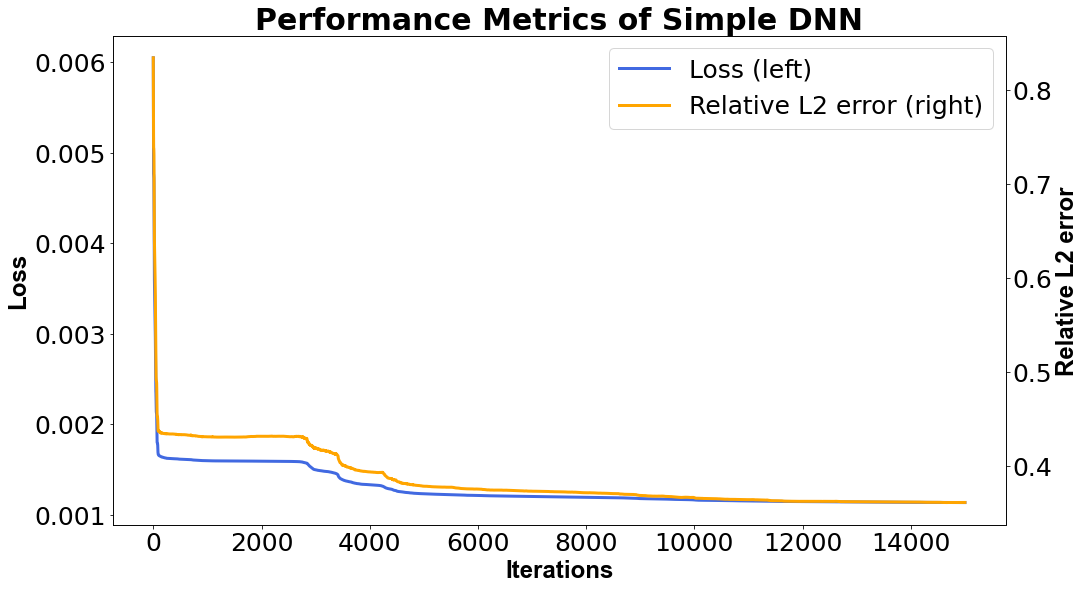

In [15]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [16]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.013165875370693182
MSE =  0.001132563149447306
RMSE =  0.03365357558190966
L2 relative error = 0.3371904824269824
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

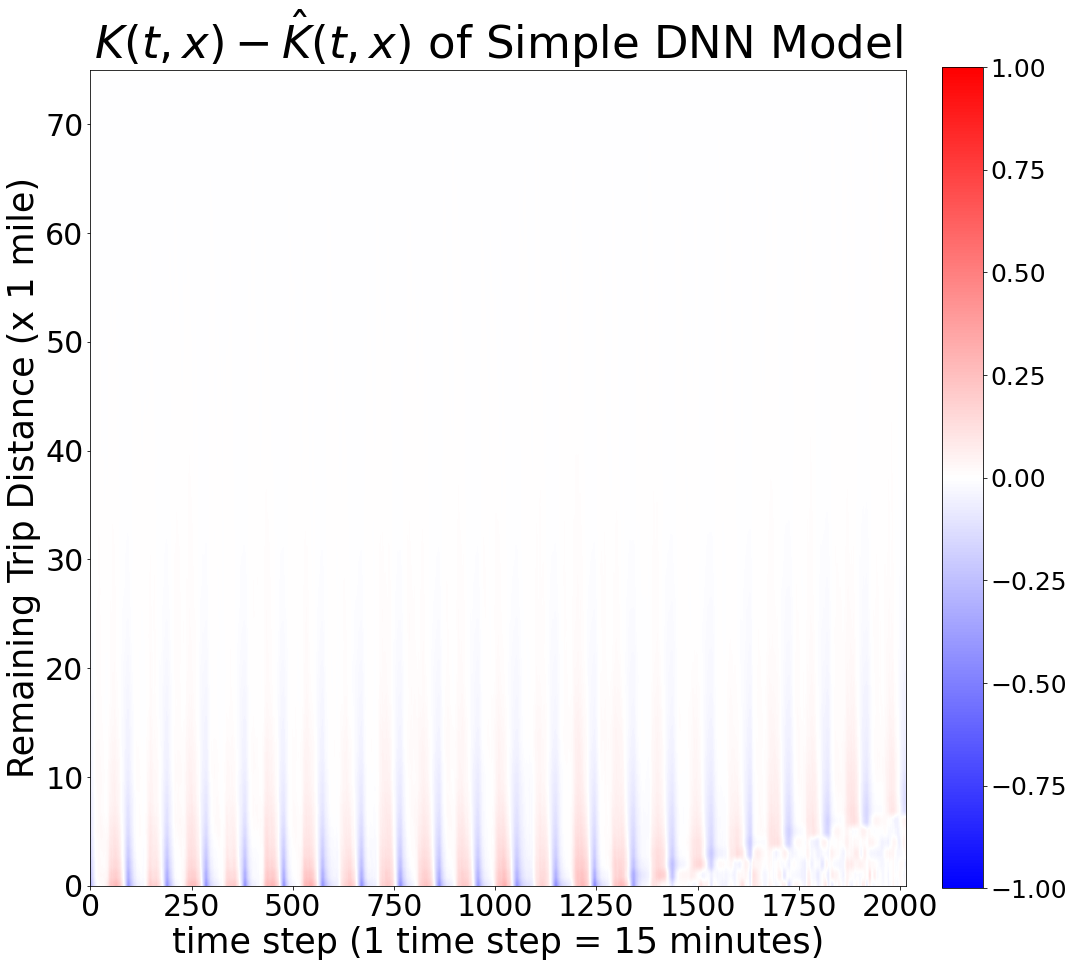

In [17]:
K_array = np.array(u_pred)
K_array = usol - K_array

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

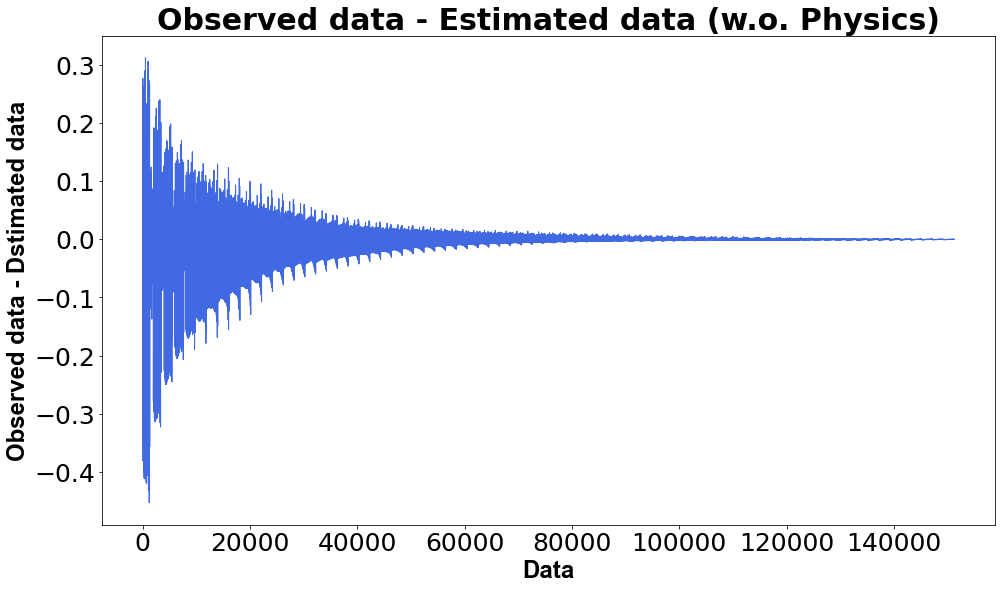

In [18]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data (w.o. Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Dstimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

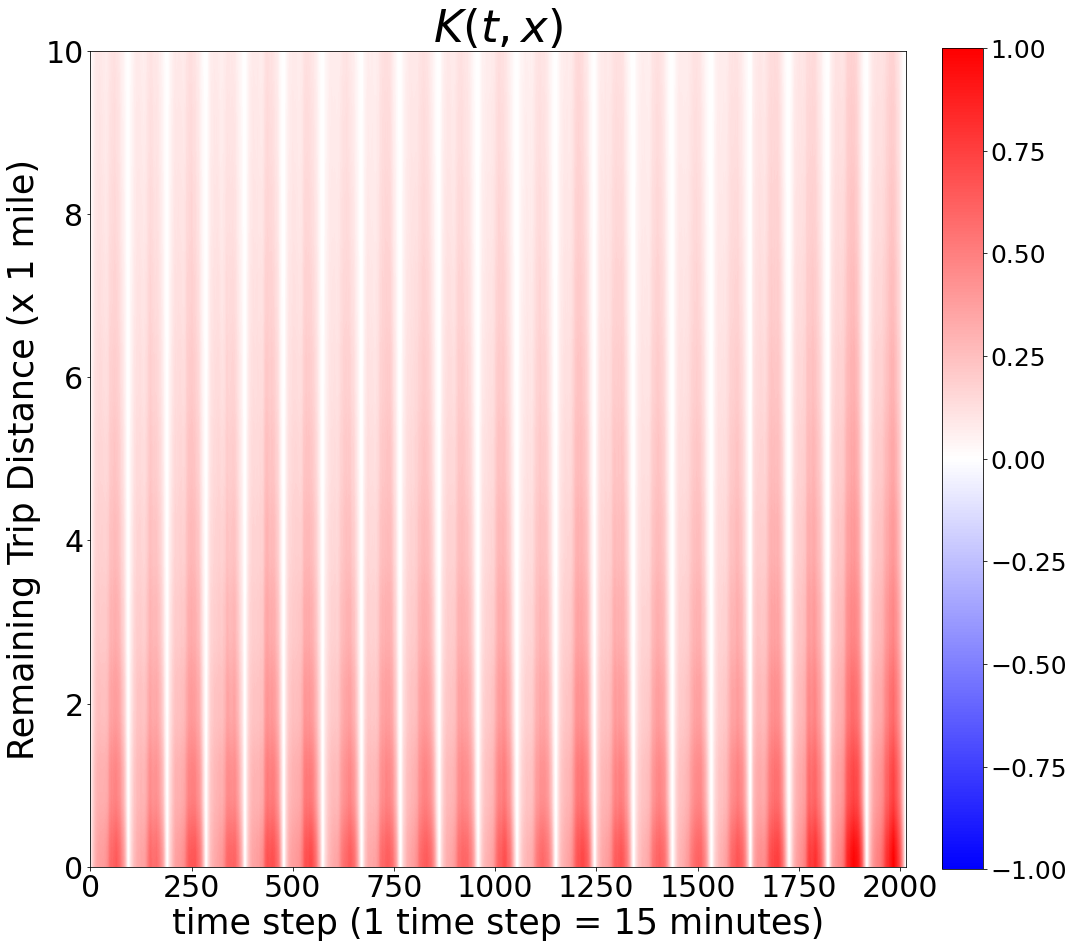

In [19]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(usol.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,10])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)$', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

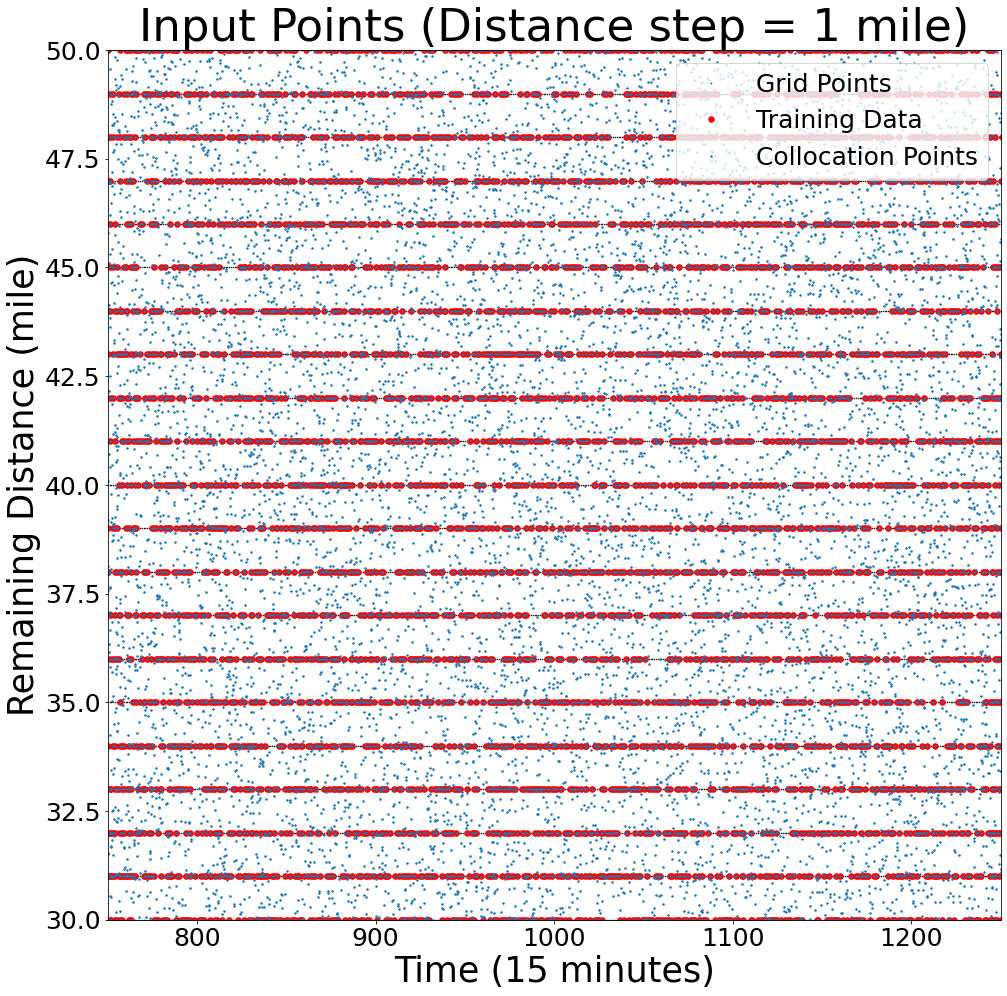

In [20]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.xlim((750,1250))
plt.ylim((30,50))
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

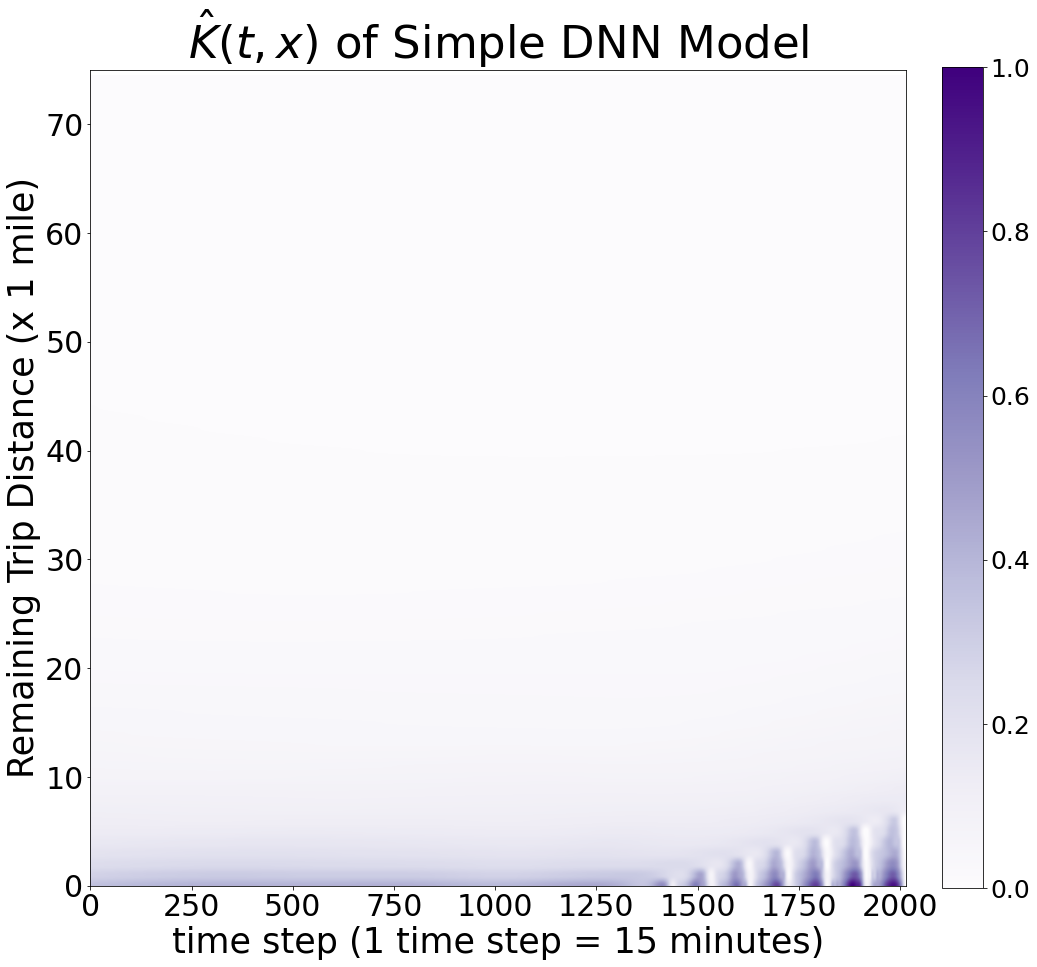

In [21]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

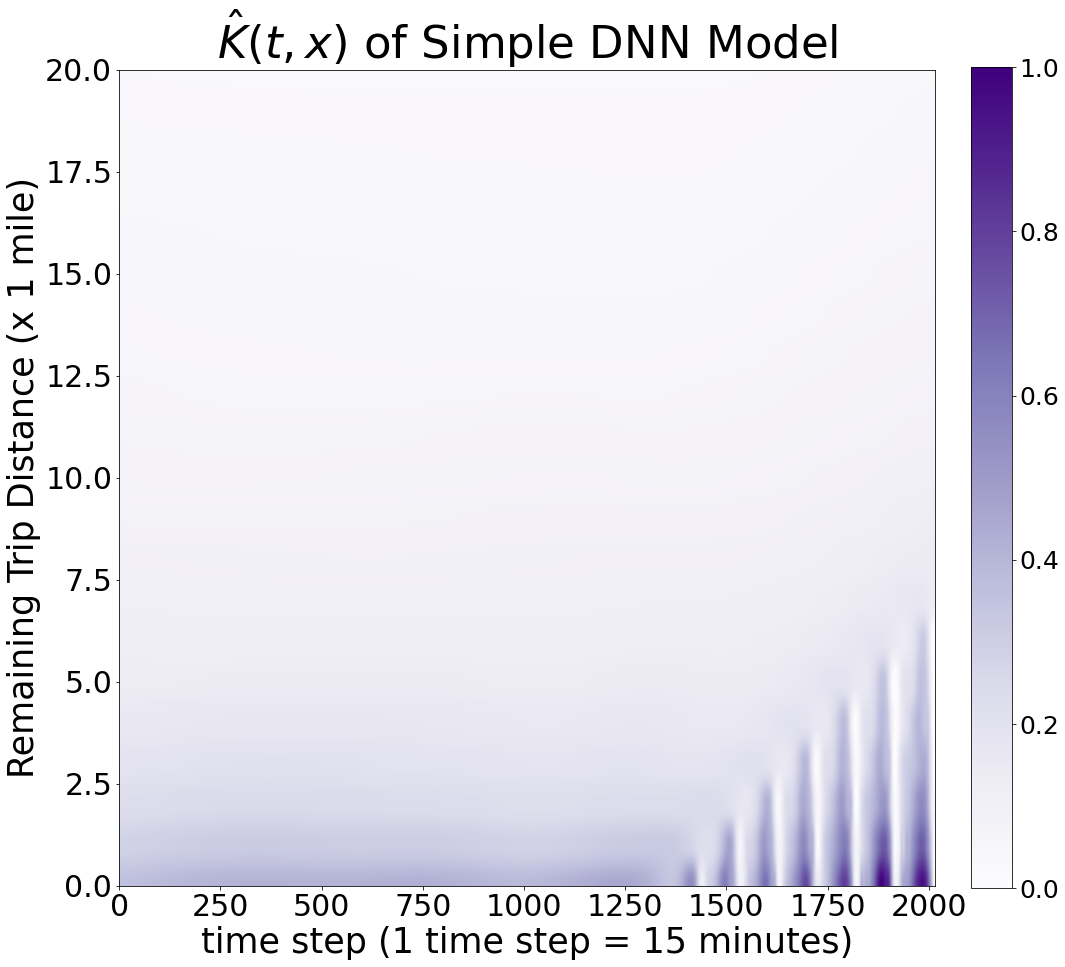

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

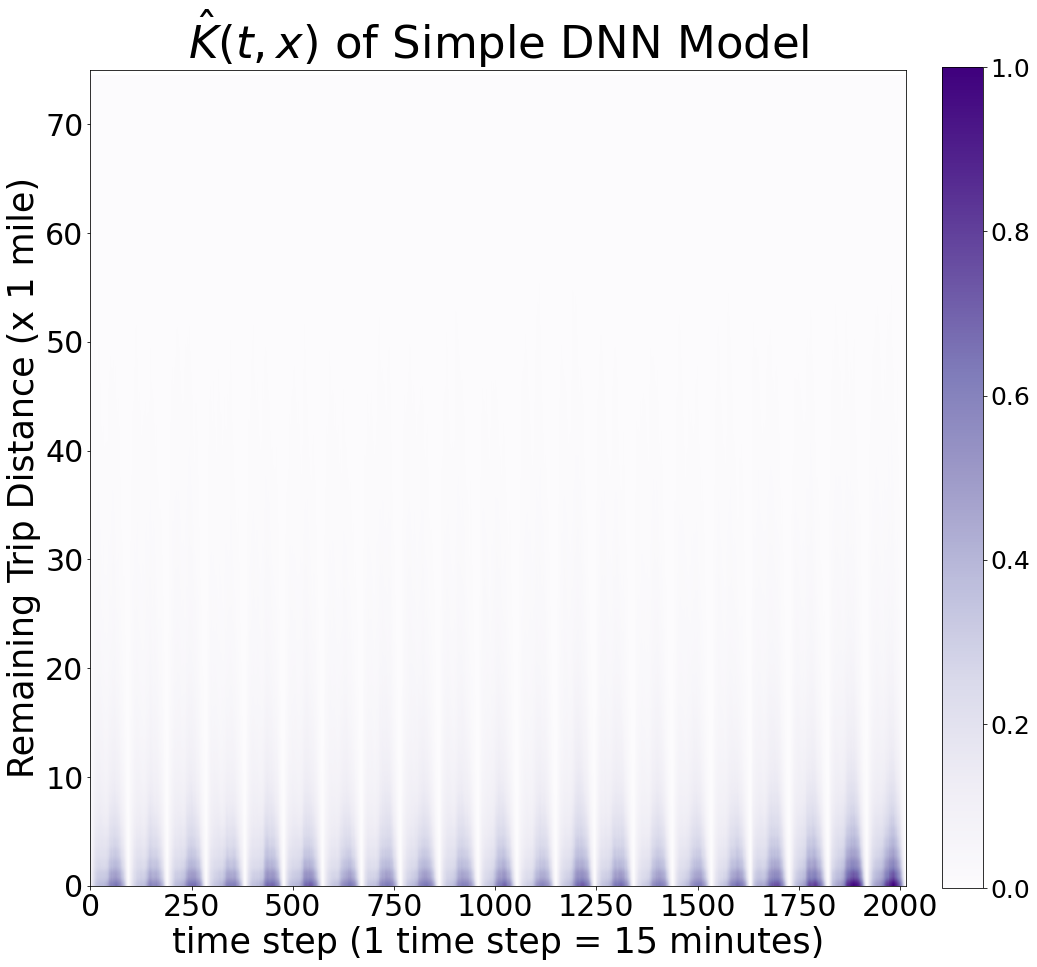

In [23]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

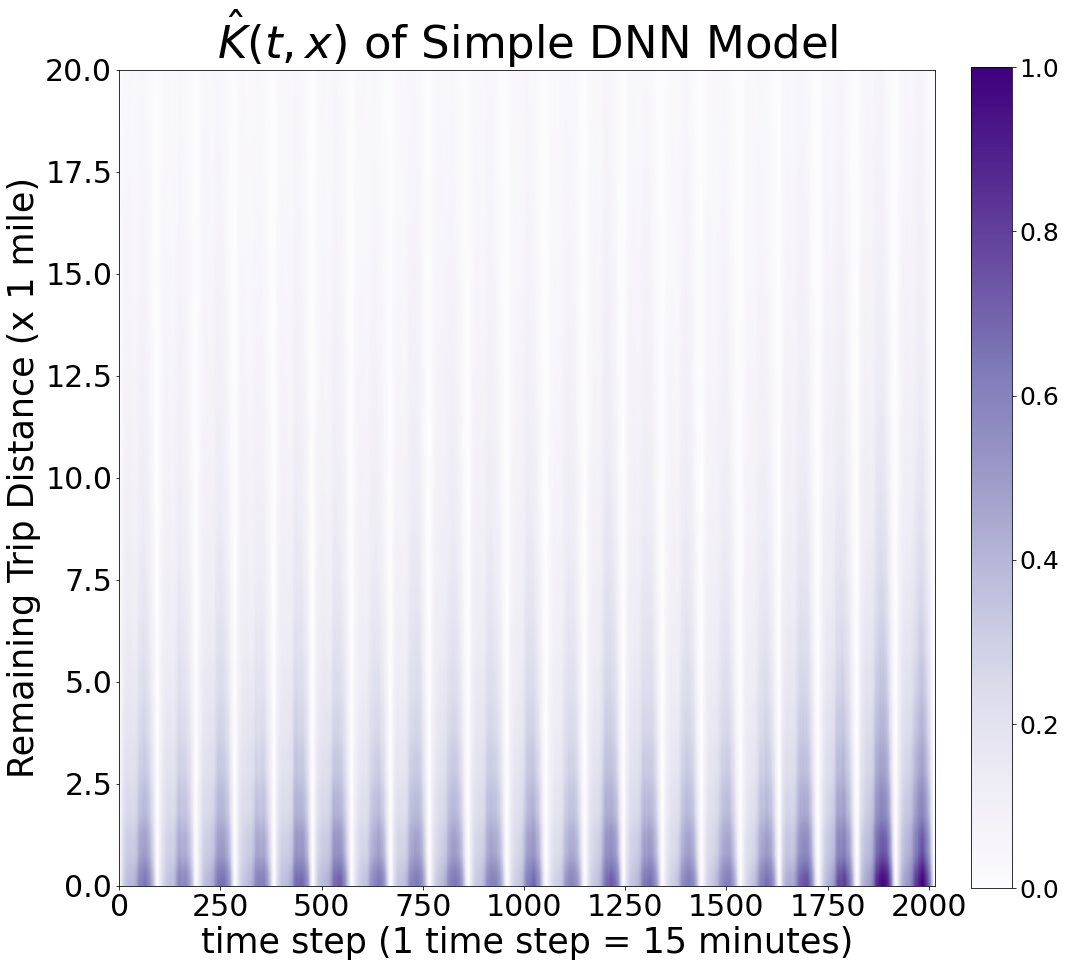

In [24]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)